In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 9295
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  VBKG0BIX_19_23_37
NN-MODEL FILENAME:  ./models/VBKG0BIX_19_23_37_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.intp)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax().astype(np.intp)
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.intp)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 20000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################


    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = node_q_table

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1317.26 MiB, increment: 1097.32 MiB
Quantization TIME:  0.02 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   15558
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 61
TOTAL SERIAL TIMESTEPS:   15558
TOTAL PARALLEL TIMESTEPS: 61


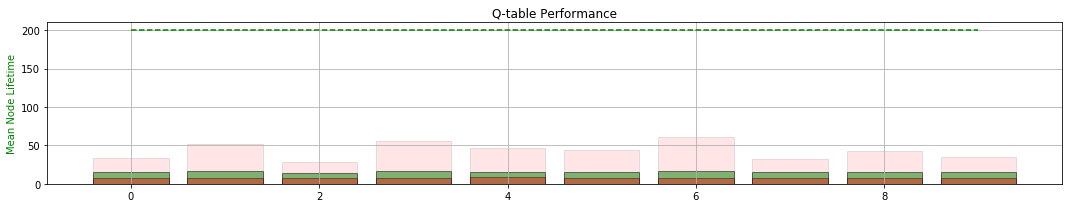

MEMORY COUNTER:  15558
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 554.511	LOSS : 494.187	LOSS : 501.537	LOSS : 462.312	LOSS : 482.520	LOSS : 453.713	LOSS : 461.374	LOSS : 438.435	
Validating... MEAN TIME:  86.275
LOSS : 427.280	LOSS : 426.650	LOSS : 437.595	LOSS : 416.630	LOSS : 417.081	LOSS : 409.456	LOSS : 399.023	LOSS : 386.797	
Validating... MEAN TIME:  100.195
LOSS : 390.277	LOSS : 394.987	LOSS : 370.245	LOSS : 380.651	LOSS : 374.989	LOSS : 378.491	LOSS : 374.128	LOSS : 374.044	
Validating... MEAN TIME:  135.185
LOSS : 373.400	LOSS : 381.074	LOSS : 372.655	LOSS : 385.132	LOSS : 376.238	LOSS : 378.128	LOSS : 380.476	LOSS : 376.502	
Validating... MEAN TIME:  143.85
LOSS : 380.154	LOSS : 392.345	LOSS : 381.279	LOSS : 387.024	LOSS : 396.467	LOSS : 392.471	LOSS : 408.981	LOSS : 388.296	
Validating... MEAN TIME:  142.985
TRAINING TIME:0:00:50.300304


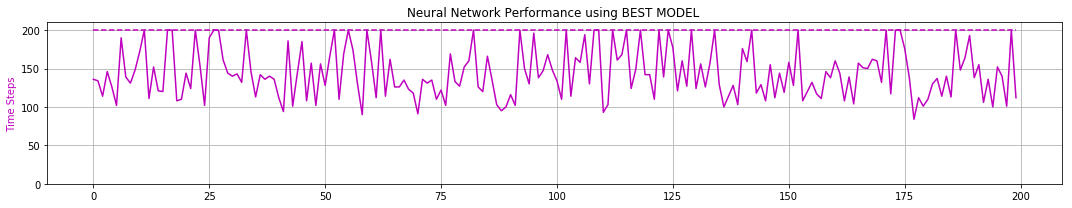

peak memory: 1371.38 MiB, increment: 1094.23 MiB
0 -max- [ 0.338  2.159  0.206  1.734]
0 -min- [-0.154 -1.207 -0.209 -2.916]

1 -max- [ 0.364  1.986  0.203  1.216]
1 -min- [-0.126 -0.943 -0.209 -2.766]

2 -max- [ 0.249  1.803  0.204  1.669]
2 -min- [-0.173 -1.027 -0.209 -2.749]

3 -max- [ 0.910  3.634  0.207  2.169]
3 -min- [-0.185 -1.331 -0.209 -3.350]

4 -max- [ 0.590  2.667  0.207  1.767]
4 -min- [-0.108 -0.981 -0.209 -2.742]

5 -max- [ 0.355  2.262  0.207  1.775]
5 -min- [-0.162 -1.120 -0.209 -2.747]

6 -max- [ 0.756  2.327  0.201  1.385]
6 -min- [-0.126 -0.976 -0.209 -3.012]

7 -max- [ 0.258  2.080  0.206  1.026]
7 -min- [-0.058 -0.627 -0.209 -2.751]

8 -max- [ 0.216  1.797  0.196  1.515]
8 -min- [-0.297 -1.496 -0.209 -2.726]

9 -max- [ 0.272  2.465  0.195  2.014]
9 -min- [-0.163 -1.167 -0.208 -2.961]

Quantization TIME:  0.02 minutes


ITERATION # 1
TOTAL EXPERIENCE GENERATED:   98392
SMALLEST TIMESTEP: 9
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   113950
TOTAL PARALLEL TIME

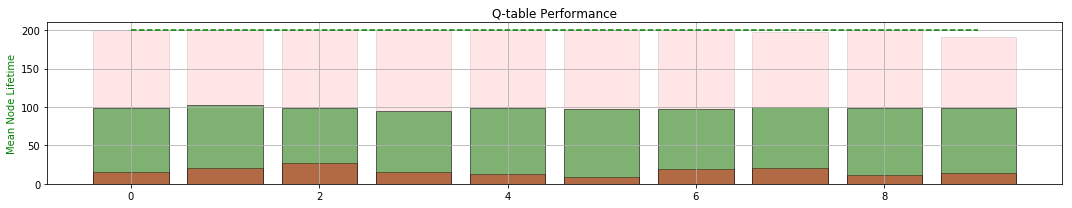

MEMORY COUNTER:  113950
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 165.544	LOSS : 165.867	LOSS : 171.057	LOSS : 175.147	LOSS : 164.830	LOSS : 158.437	LOSS : 158.561	LOSS : 180.691	
Validating... MEAN TIME:  160.925
LOSS : 162.354	LOSS : 162.797	LOSS : 163.733	LOSS : 173.202	LOSS : 156.805	LOSS : 162.233	LOSS : 165.217	LOSS : 156.150	
Validating... MEAN TIME:  159.82
LOSS : 154.409	LOSS : 156.051	LOSS : 162.645	LOSS : 165.529	LOSS : 153.931	LOSS : 160.039	LOSS : 162.175	LOSS : 154.096	
Validating... MEAN TIME:  149.12
LOSS : 156.766	LOSS : 160.454	LOSS : 154.945	LOSS : 159.696	LOSS : 174.531	LOSS : 165.598	LOSS : 158.286	LOSS : 157.837	
Validating... MEAN TIME:  152.02
LOSS : 149.877	LOSS : 161.767	LOSS : 158.447	LOSS : 162.412	LOSS : 154.487	LOSS : 160.470	LOSS : 156.010	LOSS : 150.379	
Validating... MEAN TIME:  152.54
TRAINING TIME:0:00:55.862230


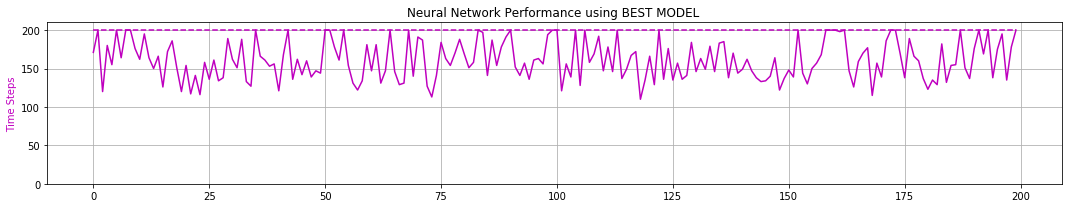

peak memory: 1426.52 MiB, increment: 1078.99 MiB
0 -max- [ 0.786  1.447  0.209  2.230]
0 -min- [-1.072 -1.891 -0.209 -1.788]

1 -max- [ 0.817  1.675  0.209  2.316]
1 -min- [-1.038 -1.937 -0.209 -2.166]

2 -max- [ 0.805  1.519  0.209  2.300]
2 -min- [-1.066 -1.876 -0.209 -1.790]

3 -max- [ 0.772  1.939  0.209  2.385]
3 -min- [-1.146 -2.146 -0.209 -2.006]

4 -max- [ 0.723  2.006  0.209  2.484]
4 -min- [-0.966 -1.936 -0.209 -1.788]

5 -max- [ 0.878  1.644  0.209  1.805]
5 -min- [-1.056 -2.087 -0.209 -2.211]

6 -max- [ 0.936  1.909  0.209  1.859]
6 -min- [-1.120 -2.028 -0.209 -1.844]

7 -max- [ 0.814  1.521  0.209  1.796]
7 -min- [-1.090 -1.974 -0.209 -2.162]

8 -max- [ 1.083  2.065  0.209  2.227]
8 -min- [-1.005 -2.010 -0.209 -2.176]

9 -max- [ 0.945  1.883  0.209  1.908]
9 -min- [-1.171 -2.083 -0.209 -2.161]

Quantization TIME:  0.02 minutes


ITERATION # 2
TOTAL EXPERIENCE GENERATED:   130527
SMALLEST TIMESTEP: 25
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   244477
TOTAL PARALLEL TI

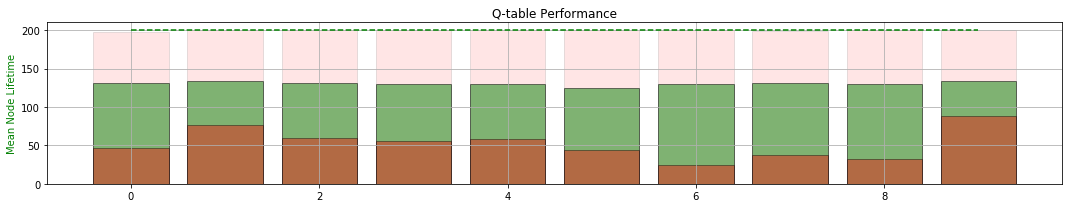

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 99.354	LOSS : 89.800	LOSS : 93.159	LOSS : 87.371	LOSS : 91.266	LOSS : 82.297	LOSS : 81.333	LOSS : 73.476	
Validating... MEAN TIME:  156.365
LOSS : 74.840	LOSS : 74.905	LOSS : 79.114	LOSS : 77.917	LOSS : 77.657	LOSS : 83.723	LOSS : 85.640	LOSS : 78.586	
Validating... MEAN TIME:  146.005
LOSS : 79.297	LOSS : 73.628	LOSS : 70.601	LOSS : 78.884	LOSS : 77.838	LOSS : 80.525	LOSS : 77.146	LOSS : 80.151	
Validating... MEAN TIME:  141.165
LOSS : 75.006	LOSS : 77.797	LOSS : 82.762	LOSS : 75.427	LOSS : 78.694	LOSS : 77.407	LOSS : 76.009	LOSS : 71.448	
Validating... MEAN TIME:  137.45
LOSS : 77.572	LOSS : 64.880	LOSS : 81.085	LOSS : 75.015	LOSS : 70.391	LOSS : 74.275	LOSS : 63.280	LOSS : 71.248	
Validating... MEAN TIME:  134.18
TRAINING TIME:0:00:58.226658


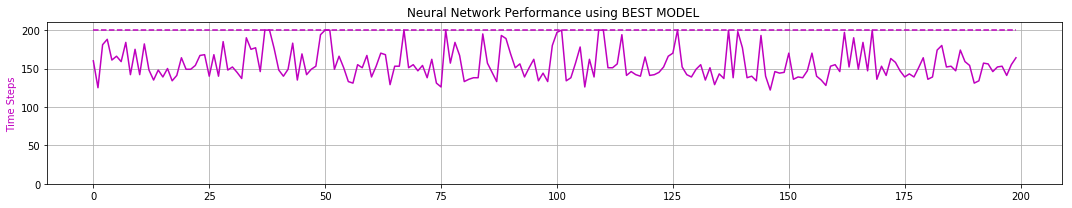

peak memory: 1407.01 MiB, increment: 1037.15 MiB
0 -max- [ 0.977  1.493  0.209  2.139]
0 -min- [-1.698 -2.416 -0.209 -1.734]

1 -max- [ 0.976  1.509  0.209  1.989]
1 -min- [-1.695 -2.433 -0.209 -1.792]

2 -max- [ 0.939  1.333  0.209  1.832]
2 -min- [-1.661 -2.393 -0.209 -2.245]

3 -max- [ 1.056  1.693  0.209  2.033]
3 -min- [-1.519 -2.176 -0.209 -1.964]

4 -max- [ 0.944  1.350  0.209  1.938]
4 -min- [-1.762 -2.580 -0.209 -2.149]

5 -max- [ 0.977  1.627  0.209  2.417]
5 -min- [-1.671 -2.409 -0.209 -1.832]

6 -max- [ 0.970  1.514  0.209  1.871]
6 -min- [-1.592 -2.400 -0.209 -1.973]

7 -max- [ 0.999  1.522  0.209  2.527]
7 -min- [-1.568 -2.354 -0.209 -1.735]

8 -max- [ 0.986  1.678  0.209  2.178]
8 -min- [-1.503 -2.213 -0.209 -1.787]

9 -max- [ 0.952  1.503  0.209  1.878]
9 -min- [-1.614 -2.371 -0.209 -2.227]

Quantization TIME:  0.01 minutes


ITERATION # 3
TOTAL EXPERIENCE GENERATED:   127199
SMALLEST TIMESTEP: 76
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   371676
TOTAL PARALLEL TI

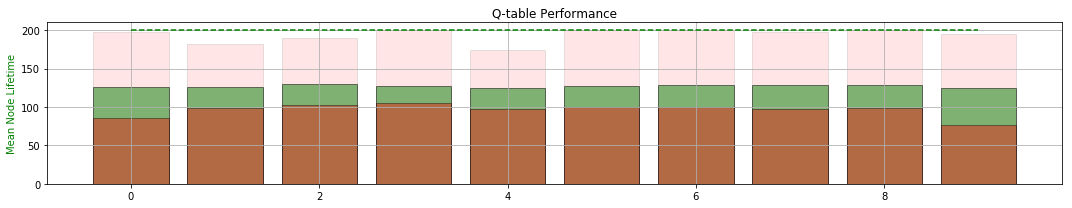

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 63.242	LOSS : 66.996	LOSS : 75.455	LOSS : 73.623	LOSS : 73.779	LOSS : 65.601	LOSS : 73.748	LOSS : 61.940	
Validating... MEAN TIME:  133.955
LOSS : 77.138	LOSS : 64.047	LOSS : 69.594	LOSS : 65.325	LOSS : 69.054	LOSS : 65.612	LOSS : 71.870	LOSS : 63.786	
Validating... MEAN TIME:  134.975
LOSS : 64.410	LOSS : 64.662	LOSS : 74.108	LOSS : 66.550	LOSS : 69.671	LOSS : 69.060	LOSS : 68.952	LOSS : 67.152	
Validating... MEAN TIME:  129.385
LOSS : 59.060	LOSS : 70.609	LOSS : 67.251	LOSS : 60.438	LOSS : 69.204	LOSS : 64.889	LOSS : 66.269	LOSS : 57.120	
Validating... MEAN TIME:  114.7
LOSS : 76.684	LOSS : 69.522	LOSS : 68.898	LOSS : 61.877	LOSS : 65.122	LOSS : 67.978	LOSS : 66.736	LOSS : 60.836	
Validating... MEAN TIME:  82.32
TRAINING TIME:0:00:50.957598


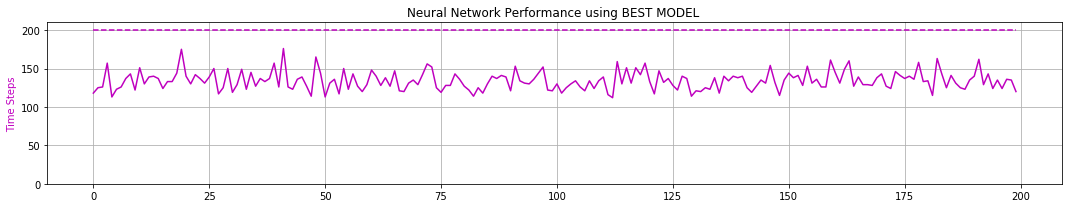

peak memory: 1491.00 MiB, increment: 1020.87 MiB
0 -max- [ 0.938  1.468  0.207  1.244]
0 -min- [-2.257 -2.726 -0.209 -1.336]

1 -max- [ 0.913  1.476  0.204  1.354]
1 -min- [-2.394 -2.939 -0.209 -1.260]

2 -max- [ 0.943  1.514  0.209  1.254]
2 -min- [-2.268 -2.768 -0.209 -1.343]

3 -max- [ 0.945  1.488  0.208  1.308]
3 -min- [-2.260 -2.699 -0.209 -1.308]

4 -max- [ 0.886  1.477  0.198  1.377]
4 -min- [-2.261 -2.752 -0.209 -1.315]

5 -max- [ 0.943  1.530  0.209  1.193]
5 -min- [-2.258 -2.734 -0.209 -1.228]

6 -max- [ 0.936  1.332  0.209  1.452]
6 -min- [-2.233 -2.762 -0.209 -1.336]

7 -max- [ 0.944  1.484  0.208  1.333]
7 -min- [-2.391 -2.925 -0.209 -1.341]

8 -max- [ 0.937  1.499  0.208  1.309]
8 -min- [-2.252 -2.600 -0.209 -1.332]

9 -max- [ 0.919  1.329  0.206  1.221]
9 -min- [-2.373 -2.927 -0.209 -1.354]

Quantization TIME:  0.02 minutes


ITERATION # 4
TOTAL EXPERIENCE GENERATED:   93787
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 173
TOTAL SERIAL TIMESTEPS:   465463
TOTAL PARALLEL TIM

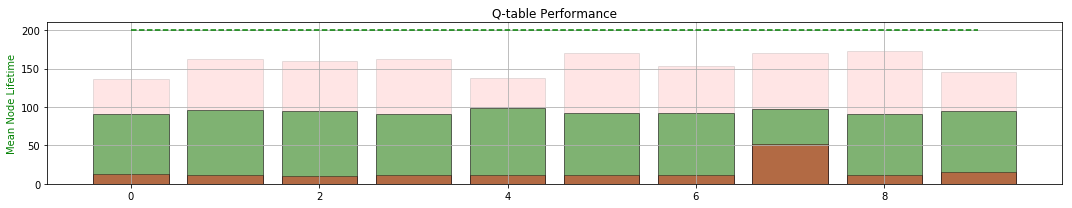

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 94.023	LOSS : 97.160	LOSS : 85.825	LOSS : 83.107	LOSS : 83.702	LOSS : 79.486	LOSS : 82.607	LOSS : 88.153	
Validating... MEAN TIME:  131.115
LOSS : 96.088	LOSS : 89.992	LOSS : 83.292	LOSS : 80.355	LOSS : 80.647	LOSS : 83.348	LOSS : 85.676	LOSS : 91.453	
Validating... MEAN TIME:  97.2
LOSS : 83.783	LOSS : 86.688	LOSS : 77.391	LOSS : 84.383	LOSS : 76.477	LOSS : 85.235	LOSS : 89.741	LOSS : 73.058	
Validating... MEAN TIME:  106.64
LOSS : 81.100	LOSS : 78.642	LOSS : 80.614	LOSS : 76.357	LOSS : 83.761	LOSS : 86.838	LOSS : 86.712	LOSS : 87.924	
Validating... MEAN TIME:  106.825
LOSS : 85.371	LOSS : 77.543	LOSS : 86.599	LOSS : 89.387	LOSS : 87.610	LOSS : 78.574	LOSS : 81.452	LOSS : 79.283	
Validating... MEAN TIME:  112.19
TRAINING TIME:0:00:48.862721


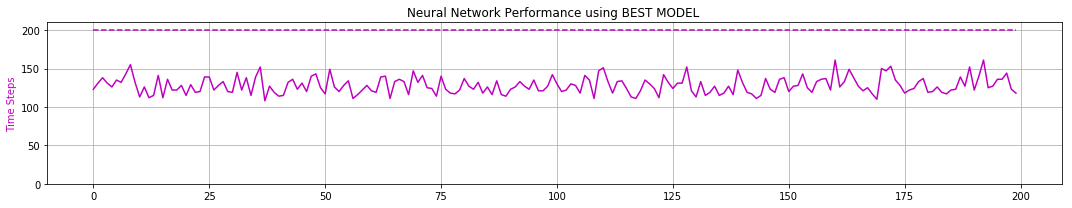

peak memory: 1493.43 MiB, increment: 978.92 MiB
0 -max- [ 0.144  1.201  0.080  1.289]
0 -min- [-2.400 -3.130 -0.209 -1.691]

1 -max- [ 0.381  1.196  0.205  1.460]
1 -min- [-2.398 -3.097 -0.209 -1.679]

2 -max- [ 0.429  1.182  0.208  1.319]
2 -min- [-2.399 -2.974 -0.209 -1.827]

3 -max- [ 0.149  1.208  0.074  1.295]
3 -min- [-2.400 -3.094 -0.209 -1.723]

4 -max- [ 0.159  1.180  0.078  1.296]
4 -min- [-2.400 -3.160 -0.209 -1.681]

5 -max- [ 0.147  1.175  0.094  1.327]
5 -min- [-2.399 -3.065 -0.209 -1.673]

6 -max- [ 0.153  1.204  0.101  1.302]
6 -min- [-2.399 -2.976 -0.209 -1.736]

7 -max- [ 0.534  1.352  0.203  1.365]
7 -min- [-2.400 -2.975 -0.209 -1.707]

8 -max- [ 0.347  1.215  0.203  1.323]
8 -min- [-2.400 -3.067 -0.209 -1.676]

9 -max- [ 0.394  1.376  0.204  1.355]
9 -min- [-2.400 -3.062 -0.209 -1.683]

Quantization TIME:  0.02 minutes


ITERATION # 5
TOTAL EXPERIENCE GENERATED:   72794
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 138
TOTAL SERIAL TIMESTEPS:   538257
TOTAL PARALLEL TIME

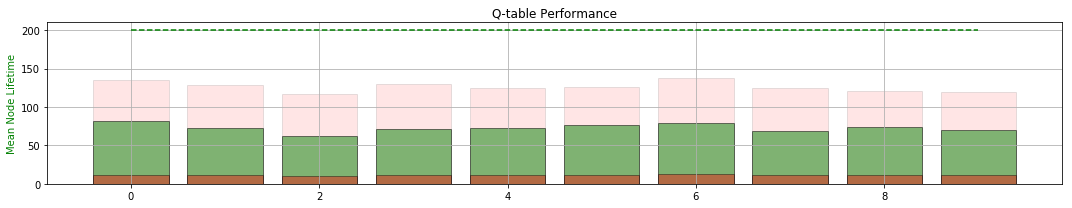

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 107.745	LOSS : 89.460	LOSS : 109.171	LOSS : 111.247	LOSS : 114.662	LOSS : 115.803	LOSS : 103.109	LOSS : 110.749	
Validating... MEAN TIME:  106.105
LOSS : 110.336	LOSS : 104.404	LOSS : 122.297	LOSS : 91.235	LOSS : 111.512	LOSS : 99.204	LOSS : 106.995	LOSS : 114.246	
Validating... MEAN TIME:  108.01
LOSS : 106.881	LOSS : 107.896	LOSS : 121.234	LOSS : 114.135	LOSS : 105.442	LOSS : 112.865	LOSS : 116.812	LOSS : 110.700	
Validating... MEAN TIME:  110.58
LOSS : 121.436	LOSS : 112.289	LOSS : 113.478	LOSS : 107.768	LOSS : 112.284	LOSS : 104.468	LOSS : 111.278	LOSS : 119.725	
Validating... MEAN TIME:  109.39
LOSS : 110.013	LOSS : 119.910	LOSS : 103.449	LOSS : 109.966	LOSS : 105.656	LOSS : 120.087	LOSS : 102.191	LOSS : 110.335	
Validating... MEAN TIME:  104.72
TRAINING TIME:0:00:47.578605


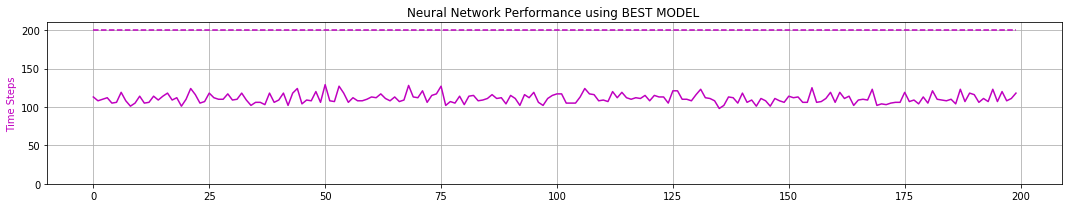

peak memory: 1446.70 MiB, increment: 1015.58 MiB
0 -max- [ 0.171  1.392  0.048  1.011]
0 -min- [-2.398 -3.166 -0.209 -1.974]

1 -max- [ 0.147  1.369  0.048  1.187]
1 -min- [-2.396 -3.105 -0.209 -1.967]

2 -max- [ 0.186  1.413  0.048  1.102]
2 -min- [-2.398 -3.163 -0.209 -1.992]

3 -max- [ 0.173  1.375  0.048  0.976]
3 -min- [-2.399 -3.142 -0.209 -1.986]

4 -max- [ 0.161  1.371  0.049  0.960]
4 -min- [-2.398 -3.115 -0.209 -1.978]

5 -max- [ 0.156  1.399  0.049  0.977]
5 -min- [-2.400 -3.100 -0.209 -1.986]

6 -max- [ 0.150  1.130  0.049  1.162]
6 -min- [-2.399 -3.165 -0.209 -1.955]

7 -max- [ 0.152  1.410  0.050  1.088]
7 -min- [-2.398 -3.094 -0.209 -1.979]

8 -max- [ 0.162  1.144  0.048  1.014]
8 -min- [-2.400 -3.163 -0.209 -1.683]

9 -max- [ 0.147  1.144  0.048  0.998]
9 -min- [-2.398 -3.161 -0.209 -1.689]

Quantization TIME:  0.01 minutes


ITERATION # 6
TOTAL EXPERIENCE GENERATED:   89910
SMALLEST TIMESTEP: 21
LARGEST  TIMESTEP: 127
TOTAL SERIAL TIMESTEPS:   628167
TOTAL PARALLEL TIM

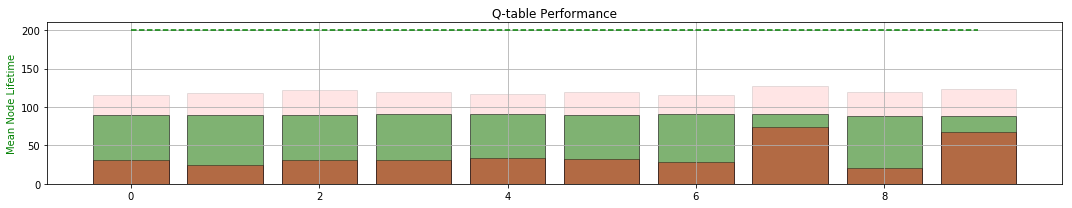

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 132.539	LOSS : 136.826	LOSS : 116.167	LOSS : 114.154	LOSS : 113.579	LOSS : 114.009	LOSS : 124.686	LOSS : 110.098	
Validating... MEAN TIME:  104.625
LOSS : 116.679	LOSS : 117.408	LOSS : 109.984	LOSS : 114.944	LOSS : 106.511	LOSS : 115.845	LOSS : 111.953	LOSS : 114.859	
Validating... MEAN TIME:  105.61
LOSS : 104.875	LOSS : 105.038	LOSS : 112.244	LOSS : 110.909	LOSS : 104.592	LOSS : 110.823	LOSS : 113.982	LOSS : 116.310	
Validating... MEAN TIME:  106.375
LOSS : 101.408	LOSS : 115.319	LOSS : 92.679	LOSS : 107.294	LOSS : 115.163	LOSS : 108.294	LOSS : 114.011	LOSS : 114.199	
Validating... MEAN TIME:  107.695
LOSS : 106.851	LOSS : 113.415	LOSS : 115.163	LOSS : 102.165	LOSS : 108.656	LOSS : 100.202	LOSS : 108.094	LOSS : 109.484	
Validating... MEAN TIME:  104.255
TRAINING TIME:0:00:48.496232


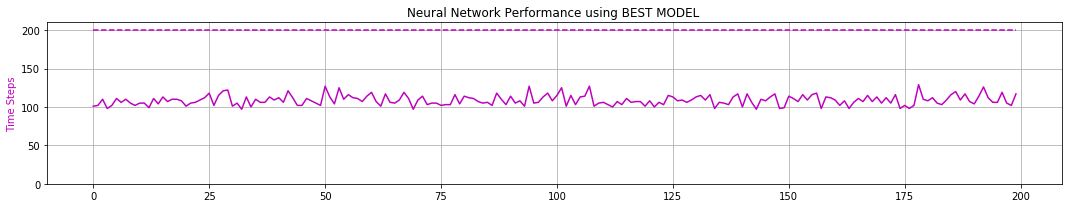

peak memory: 1474.31 MiB, increment: 1015.12 MiB
0 -max- [ 0.136  0.828  0.048  0.863]
0 -min- [-2.399 -3.264 -0.209 -1.175]

1 -max- [ 0.140  0.826  0.053  1.004]
1 -min- [-2.400 -3.162 -0.209 -1.148]

2 -max- [ 0.132  0.820  0.048  0.781]
2 -min- [-2.399 -3.254 -0.209 -1.166]

3 -max- [ 0.135  0.829  0.049  1.046]
3 -min- [-2.400 -3.351 -0.209 -1.186]

4 -max- [ 0.128  0.824  0.049  0.833]
4 -min- [-2.395 -3.156 -0.209 -1.211]

5 -max- [ 0.144  0.818  0.049  0.693]
5 -min- [-2.397 -3.279 -0.209 -1.207]

6 -max- [ 0.141  0.826  0.052  0.903]
6 -min- [-2.400 -3.164 -0.209 -1.172]

7 -max- [ 0.156  0.828  0.048  0.686]
7 -min- [-2.400 -3.299 -0.209 -1.155]

8 -max- [ 0.125  0.818  0.048  0.917]
8 -min- [-2.399 -3.322 -0.209 -1.205]

9 -max- [ 0.149  0.958  0.051  0.827]
9 -min- [-2.396 -3.159 -0.209 -1.441]

Quantization TIME:  0.02 minutes


ITERATION # 7
TOTAL EXPERIENCE GENERATED:   102170
SMALLEST TIMESTEP: 33
LARGEST  TIMESTEP: 159
TOTAL SERIAL TIMESTEPS:   730337
TOTAL PARALLEL TI

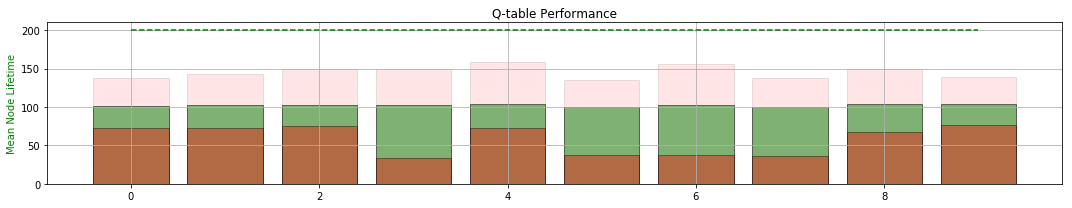

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 106.240	LOSS : 118.044	LOSS : 114.421	LOSS : 102.555	LOSS : 97.340	LOSS : 95.864	LOSS : 106.101	LOSS : 98.396	
Validating... MEAN TIME:  98.435
LOSS : 92.561	LOSS : 86.951	LOSS : 97.167	LOSS : 96.055	LOSS : 92.675	LOSS : 105.907	LOSS : 95.932	LOSS : 115.518	
Validating... MEAN TIME:  109.895
LOSS : 101.377	LOSS : 102.098	LOSS : 100.764	LOSS : 110.877	LOSS : 106.029	LOSS : 108.833	LOSS : 94.703	LOSS : 96.214	
Validating... MEAN TIME:  103.735
LOSS : 109.252	LOSS : 93.419	LOSS : 93.904	LOSS : 103.365	LOSS : 105.203	LOSS : 94.518	LOSS : 89.474	LOSS : 102.385	
Validating... MEAN TIME:  105.535
LOSS : 111.471	LOSS : 110.183	LOSS : 113.132	LOSS : 110.136	LOSS : 93.697	LOSS : 104.611	LOSS : 106.332	LOSS : 100.939	
Validating... MEAN TIME:  105.94
TRAINING TIME:0:00:47.576793


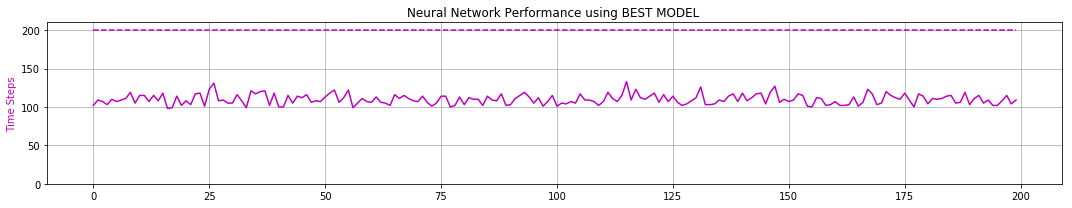

peak memory: 1479.51 MiB, increment: 978.54 MiB
0 -max- [ 0.112  0.826  0.046  0.850]
0 -min- [-2.399 -3.439 -0.209 -1.155]

1 -max- [ 0.112  0.820  0.048  0.812]
1 -min- [-2.399 -3.453 -0.209 -1.166]

2 -max- [ 0.117  0.825  0.049  0.979]
2 -min- [-2.399 -3.468 -0.209 -1.203]

3 -max- [ 0.131  0.997  0.049  0.870]
3 -min- [-2.400 -3.507 -0.209 -1.418]

4 -max- [ 0.155  0.810  0.057  0.840]
4 -min- [-2.394 -3.481 -0.209 -1.171]

5 -max- [ 0.120  0.826  0.050  0.873]
5 -min- [-2.398 -3.481 -0.209 -1.172]

6 -max- [ 0.134  0.828  0.048  0.838]
6 -min- [-2.399 -3.442 -0.209 -1.155]

7 -max- [ 0.107  0.957  0.048  0.912]
7 -min- [-2.399 -3.465 -0.209 -1.505]

8 -max- [ 0.126  0.825  0.051  0.891]
8 -min- [-2.399 -3.484 -0.209 -1.207]

9 -max- [ 0.105  0.823  0.049  0.838]
9 -min- [-2.399 -3.505 -0.209 -1.167]

Quantization TIME:  0.02 minutes


ITERATION # 8
TOTAL EXPERIENCE GENERATED:   93593
SMALLEST TIMESTEP: 35
LARGEST  TIMESTEP: 154
TOTAL SERIAL TIMESTEPS:   823930
TOTAL PARALLEL TIME

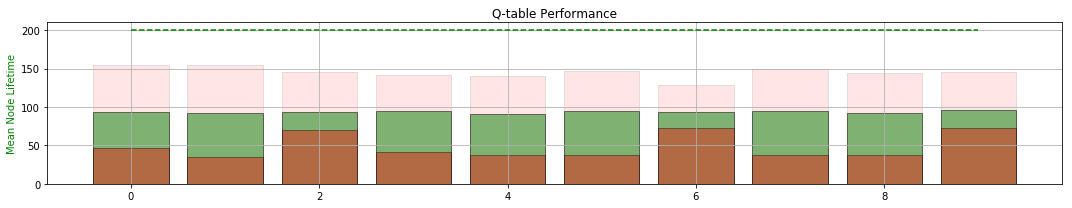

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 98.098	LOSS : 88.290	LOSS : 86.482	LOSS : 91.623	LOSS : 82.353	LOSS : 90.074	LOSS : 85.659	LOSS : 90.893	
Validating... MEAN TIME:  114.87
LOSS : 92.816	LOSS : 90.636	LOSS : 93.206	LOSS : 87.696	LOSS : 101.189	LOSS : 92.976	LOSS : 82.975	LOSS : 91.611	
Validating... MEAN TIME:  111.035
LOSS : 90.664	LOSS : 92.254	LOSS : 99.586	LOSS : 92.026	LOSS : 89.990	LOSS : 97.529	LOSS : 90.175	LOSS : 97.484	
Validating... MEAN TIME:  109.085
LOSS : 99.899	LOSS : 93.834	LOSS : 102.472	LOSS : 87.101	LOSS : 88.110	LOSS : 90.877	LOSS : 92.257	LOSS : 89.289	
Validating... MEAN TIME:  115.84
LOSS : 97.766	LOSS : 90.533	LOSS : 100.887	LOSS : 88.590	LOSS : 96.338	LOSS : 82.661	LOSS : 87.418	LOSS : 88.551	
Validating... MEAN TIME:  120.255
TRAINING TIME:0:00:49.330617


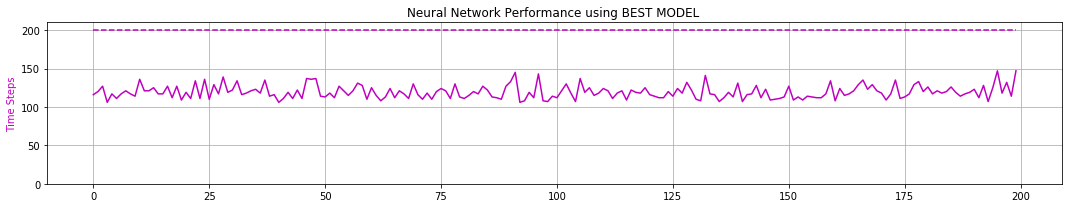

peak memory: 1499.04 MiB, increment: 978.41 MiB
0 -max- [ 0.121  0.628  0.048  0.711]
0 -min- [-2.396 -3.313 -0.209 -1.108]

1 -max- [ 0.123  0.758  0.049  0.940]
1 -min- [-2.400 -3.258 -0.209 -1.097]

2 -max- [ 0.099  0.799  0.049  0.692]
2 -min- [-2.400 -3.264 -0.209 -1.175]

3 -max- [ 0.128  0.803  0.049  0.837]
3 -min- [-2.399 -3.262 -0.209 -1.074]

4 -max- [ 0.118  0.825  0.050  0.757]
4 -min- [-2.398 -3.291 -0.209 -1.099]

5 -max- [ 0.134  0.824  0.048  0.764]
5 -min- [-2.397 -3.293 -0.209 -1.089]

6 -max- [ 0.106  0.636  0.048  0.797]
6 -min- [-2.393 -3.310 -0.209 -0.974]

7 -max- [ 0.134  0.825  0.051  0.707]
7 -min- [-2.397 -3.256 -0.209 -1.189]

8 -max- [ 0.120  0.762  0.049  0.852]
8 -min- [-2.384 -3.346 -0.209 -1.169]

9 -max- [ 0.103  0.777  0.052  0.787]
9 -min- [-2.398 -3.284 -0.209 -1.077]

Quantization TIME:  0.02 minutes


ITERATION # 9
TOTAL EXPERIENCE GENERATED:   116146
SMALLEST TIMESTEP: 47
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   940076
TOTAL PARALLEL TIM

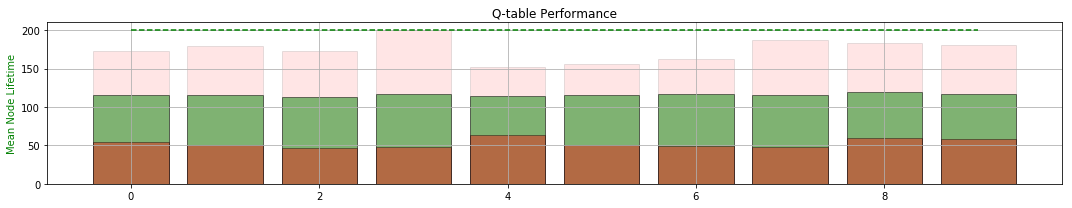

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 83.595	LOSS : 89.650	LOSS : 90.380	LOSS : 83.818	LOSS : 87.052	LOSS : 72.629	LOSS : 82.148	LOSS : 76.453	
Validating... MEAN TIME:  115.385
LOSS : 81.480	LOSS : 72.476	LOSS : 78.526	LOSS : 78.054	LOSS : 86.721	LOSS : 74.539	LOSS : 65.253	LOSS : 82.523	
Validating... MEAN TIME:  132.13
LOSS : 73.537	LOSS : 77.495	LOSS : 75.754	LOSS : 72.785	LOSS : 73.113	LOSS : 76.832	LOSS : 73.371	LOSS : 82.135	
Validating... MEAN TIME:  117.99
LOSS : 84.959	LOSS : 70.575	LOSS : 77.161	LOSS : 76.286	LOSS : 77.453	LOSS : 70.801	LOSS : 75.872	LOSS : 70.368	
Validating... MEAN TIME:  112.4
LOSS : 73.399	LOSS : 82.133	LOSS : 79.797	LOSS : 74.489	LOSS : 75.580	LOSS : 77.422	LOSS : 78.144	LOSS : 74.470	
Validating... MEAN TIME:  107.73
TRAINING TIME:0:00:50.068118


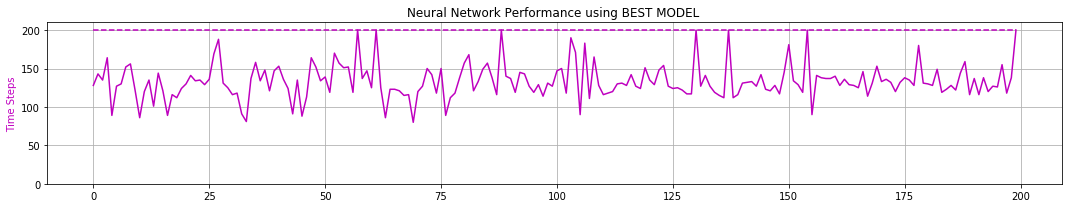

peak memory: 1494.78 MiB, increment: 1046.43 MiB
0 -max- [ 0.548  1.293  0.209  1.291]
0 -min- [-2.247 -2.695 -0.209 -1.382]

1 -max- [ 0.547  1.296  0.209  1.012]
1 -min- [-2.212 -2.511 -0.209 -1.184]

2 -max- [ 0.553  1.287  0.208  1.150]
2 -min- [-2.297 -2.614 -0.209 -1.291]

3 -max- [ 0.552  1.334  0.208  1.028]
3 -min- [-2.292 -2.573 -0.209 -1.365]

4 -max- [ 0.528  1.234  0.209  1.051]
4 -min- [-2.176 -2.527 -0.209 -1.159]

5 -max- [ 0.548  1.280  0.209  1.143]
5 -min- [-2.304 -2.577 -0.209 -1.153]

6 -max- [ 0.549  1.285  0.209  1.200]
6 -min- [-2.213 -2.571 -0.209 -1.187]

7 -max- [ 0.536  1.289  0.208  1.239]
7 -min- [-2.105 -2.510 -0.209 -1.202]

8 -max- [ 0.529  1.318  0.207  1.272]
8 -min- [-2.171 -2.587 -0.209 -1.316]

9 -max- [ 0.531  1.281  0.208  1.149]
9 -min- [-2.370 -2.703 -0.209 -1.197]

Quantization TIME:  0.02 minutes


ITERATION # 10
TOTAL EXPERIENCE GENERATED:   126086
SMALLEST TIMESTEP: 50
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1066162
TOTAL PARALLEL 

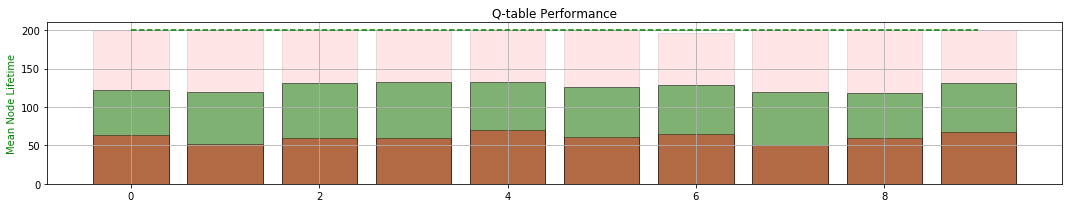

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 70.158	LOSS : 73.585	LOSS : 79.540	LOSS : 70.037	LOSS : 76.930	LOSS : 73.633	LOSS : 75.195	LOSS : 87.295	
Validating... MEAN TIME:  107.295
LOSS : 85.922	LOSS : 77.348	LOSS : 75.531	LOSS : 83.129	LOSS : 79.609	LOSS : 79.371	LOSS : 72.756	LOSS : 75.854	
Validating... MEAN TIME:  113.19
LOSS : 74.705	LOSS : 64.869	LOSS : 74.691	LOSS : 83.501	LOSS : 75.564	LOSS : 81.064	LOSS : 86.988	LOSS : 65.834	
Validating... MEAN TIME:  110.82
LOSS : 70.875	LOSS : 77.025	LOSS : 78.797	LOSS : 75.693	LOSS : 73.797	LOSS : 75.039	LOSS : 70.094	LOSS : 84.737	
Validating... MEAN TIME:  108.615
LOSS : 81.205	LOSS : 76.581	LOSS : 86.847	LOSS : 79.285	LOSS : 76.315	LOSS : 79.208	LOSS : 69.131	LOSS : 66.933	
Validating... MEAN TIME:  115.605
TRAINING TIME:0:00:48.535562


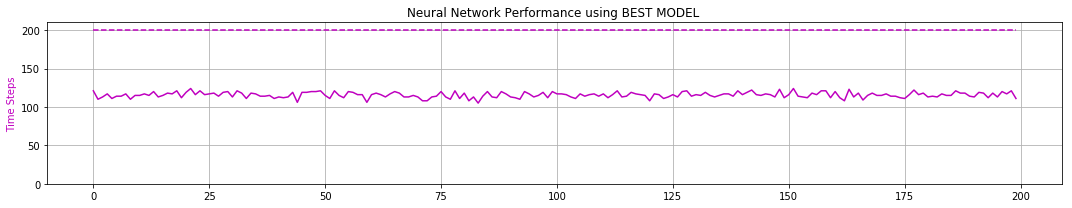

peak memory: 1459.56 MiB, increment: 1051.50 MiB
0 -max- [ 0.502  1.331  0.209  1.528]
0 -min- [-2.367 -2.966 -0.209 -1.383]

1 -max- [ 0.553  1.261  0.209  1.554]
1 -min- [-2.398 -2.973 -0.209 -1.390]

2 -max- [ 0.495  1.331  0.209  1.647]
2 -min- [-2.390 -3.148 -0.209 -1.616]

3 -max- [ 0.497  1.304  0.209  1.559]
3 -min- [-1.546 -2.385 -0.209 -1.427]

4 -max- [ 0.504  1.307  0.209  1.650]
4 -min- [-2.400 -2.956 -0.209 -1.437]

5 -max- [ 0.502  1.319  0.209  1.484]
5 -min- [-2.392 -3.141 -0.209 -1.377]

6 -max- [ 0.499  1.266  0.209  1.505]
6 -min- [-1.666 -2.268 -0.209 -1.681]

7 -max- [ 0.494  1.459  0.209  1.523]
7 -min- [-2.385 -3.168 -0.209 -1.382]

8 -max- [ 0.514  1.282  0.209  1.505]
8 -min- [-2.338 -3.149 -0.209 -1.692]

9 -max- [ 0.496  1.154  0.209  1.487]
9 -min- [-2.393 -2.974 -0.209 -1.368]

Quantization TIME:  0.02 minutes


ITERATION # 11
TOTAL EXPERIENCE GENERATED:   116107
SMALLEST TIMESTEP: 60
LARGEST  TIMESTEP: 177
TOTAL SERIAL TIMESTEPS:   1182269
TOTAL PARALLEL 

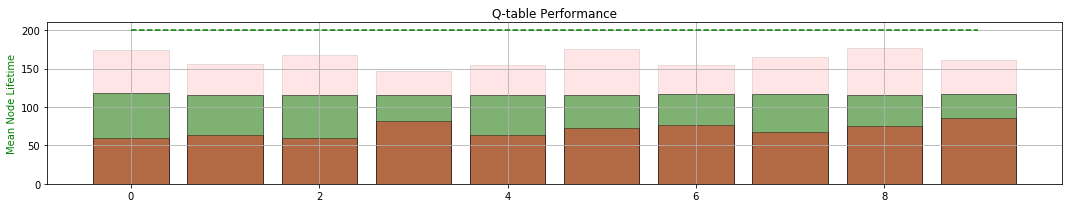

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 82.896	LOSS : 66.847	LOSS : 69.697	LOSS : 79.472	LOSS : 65.399	LOSS : 80.216	LOSS : 75.517	LOSS : 82.791	
Validating... MEAN TIME:  139.045
LOSS : 74.817	LOSS : 68.965	LOSS : 87.081	LOSS : 85.337	LOSS : 84.573	LOSS : 83.868	LOSS : 75.871	LOSS : 80.739	
Validating... MEAN TIME:  126.065
LOSS : 78.471	LOSS : 74.632	LOSS : 77.223	LOSS : 81.905	LOSS : 81.123	LOSS : 85.518	LOSS : 68.113	LOSS : 74.035	
Validating... MEAN TIME:  119.73
LOSS : 75.789	LOSS : 76.982	LOSS : 72.243	LOSS : 82.276	LOSS : 80.871	LOSS : 77.951	LOSS : 69.739	LOSS : 70.963	
Validating... MEAN TIME:  108.895
LOSS : 57.677	LOSS : 76.243	LOSS : 67.780	LOSS : 69.585	LOSS : 75.817	LOSS : 65.847	LOSS : 65.990	LOSS : 69.180	
Validating... MEAN TIME:  120.54
TRAINING TIME:0:00:51.769991


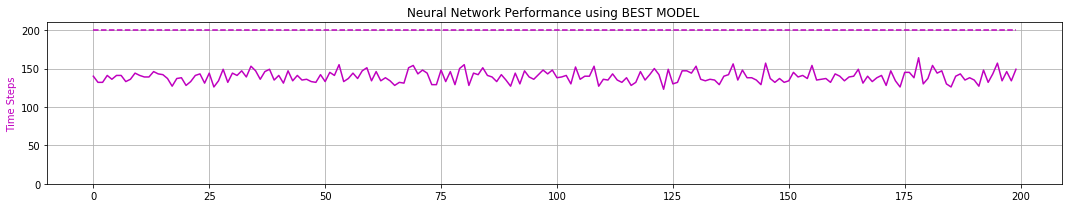

peak memory: 1482.55 MiB, increment: 1015.91 MiB
0 -max- [ 0.382  0.944  0.204  1.033]
0 -min- [-2.399 -3.320 -0.206 -1.190]

1 -max- [ 0.360  0.873  0.209  1.015]
1 -min- [-2.399 -3.337 -0.207 -1.181]

2 -max- [ 0.391  0.958  0.209  1.014]
2 -min- [-2.400 -3.324 -0.196 -1.179]

3 -max- [ 0.387  0.953  0.208  1.056]
3 -min- [-2.399 -3.291 -0.204 -1.159]

4 -max- [ 0.380  0.961  0.202  0.979]
4 -min- [-2.399 -3.340 -0.200 -1.193]

5 -max- [ 0.383  0.952  0.206  0.978]
5 -min- [-2.399 -3.310 -0.206 -1.195]

6 -max- [ 0.377  0.960  0.205  0.964]
6 -min- [-2.400 -3.311 -0.206 -1.422]

7 -max- [ 0.374  0.949  0.205  0.932]
7 -min- [-2.400 -3.298 -0.195 -1.170]

8 -max- [ 0.378  0.975  0.209  1.078]
8 -min- [-2.400 -3.177 -0.204 -1.166]

9 -max- [ 0.362  0.775  0.198  0.913]
9 -min- [-2.400 -3.331 -0.208 -1.187]

Quantization TIME:  0.02 minutes


ITERATION # 12
TOTAL EXPERIENCE GENERATED:   126151
SMALLEST TIMESTEP: 54
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1308420
TOTAL PARALLEL 

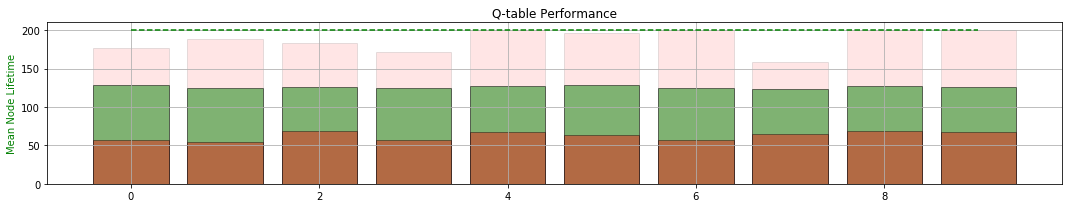

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 73.337	LOSS : 64.780	LOSS : 70.151	LOSS : 69.831	LOSS : 81.104	LOSS : 81.698	LOSS : 75.725	LOSS : 75.871	
Validating... MEAN TIME:  107.37
LOSS : 83.009	LOSS : 89.656	LOSS : 85.716	LOSS : 84.822	LOSS : 79.537	LOSS : 78.727	LOSS : 89.677	LOSS : 75.541	
Validating... MEAN TIME:  108.07
LOSS : 85.511	LOSS : 76.262	LOSS : 94.430	LOSS : 84.641	LOSS : 80.006	LOSS : 90.587	LOSS : 87.117	LOSS : 85.102	
Validating... MEAN TIME:  123.945
LOSS : 82.971	LOSS : 82.957	LOSS : 82.840	LOSS : 69.469	LOSS : 87.542	LOSS : 87.298	LOSS : 77.022	LOSS : 80.218	
Validating... MEAN TIME:  107.54
LOSS : 69.312	LOSS : 63.622	LOSS : 84.596	LOSS : 79.852	LOSS : 79.343	LOSS : 82.899	LOSS : 75.278	LOSS : 84.685	
Validating... MEAN TIME:  126.53
TRAINING TIME:0:00:49.411588


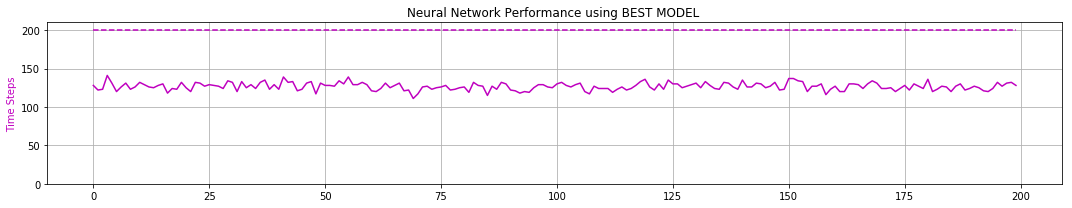

peak memory: 1464.36 MiB, increment: 1016.98 MiB
0 -max- [ 0.359  0.959  0.209  1.196]
0 -min- [-2.398 -3.125 -0.209 -1.166]

1 -max- [ 0.359  0.968  0.209  1.022]
1 -min- [-2.398 -3.133 -0.209 -1.178]

2 -max- [ 0.367  1.080  0.209  1.027]
2 -min- [-2.390 -3.155 -0.209 -1.159]

3 -max- [ 0.364  1.111  0.209  0.991]
3 -min- [-2.398 -2.984 -0.209 -1.149]

4 -max- [ 0.376  0.950  0.208  0.990]
4 -min- [-2.398 -3.069 -0.209 -1.167]

5 -max- [ 0.362  0.959  0.208  0.998]
5 -min- [-2.398 -3.159 -0.209 -1.172]

6 -max- [ 0.364  0.958  0.209  1.159]
6 -min- [-2.398 -3.148 -0.209 -1.149]

7 -max- [ 0.355  0.961  0.209  0.996]
7 -min- [-2.399 -3.167 -0.209 -1.166]

8 -max- [ 0.378  0.956  0.209  1.052]
8 -min- [-2.397 -3.162 -0.209 -1.160]

9 -max- [ 0.360  0.959  0.209  1.025]
9 -min- [-2.397 -3.166 -0.209 -1.159]

Quantization TIME:  0.02 minutes


ITERATION # 13
TOTAL EXPERIENCE GENERATED:   114511
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 135
TOTAL SERIAL TIMESTEPS:   1422931
TOTAL PARALLEL 

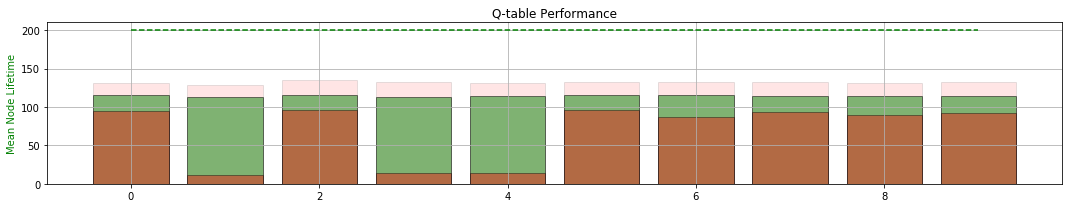

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 92.709	LOSS : 87.536	LOSS : 83.588	LOSS : 83.137	LOSS : 80.797	LOSS : 87.408	LOSS : 79.004	LOSS : 76.606	
Validating... MEAN TIME:  131.645
LOSS : 76.673	LOSS : 73.080	LOSS : 83.937	LOSS : 80.270	LOSS : 78.450	LOSS : 77.352	LOSS : 75.090	LOSS : 80.393	
Validating... MEAN TIME:  137.735
LOSS : 78.541	LOSS : 92.970	LOSS : 88.418	LOSS : 81.097	LOSS : 82.018	LOSS : 79.226	LOSS : 84.544	LOSS : 82.268	
Validating... MEAN TIME:  129.86
LOSS : 73.902	LOSS : 81.427	LOSS : 81.136	LOSS : 80.595	LOSS : 84.331	LOSS : 85.121	LOSS : 86.210	LOSS : 83.910	
Validating... MEAN TIME:  186.96
LOSS : 85.143	LOSS : 77.706	LOSS : 84.262	LOSS : 86.511	LOSS : 76.966	LOSS : 82.541	LOSS : 86.717	LOSS : 78.030	
Validating... MEAN TIME:  137.64
TRAINING TIME:0:00:54.112670


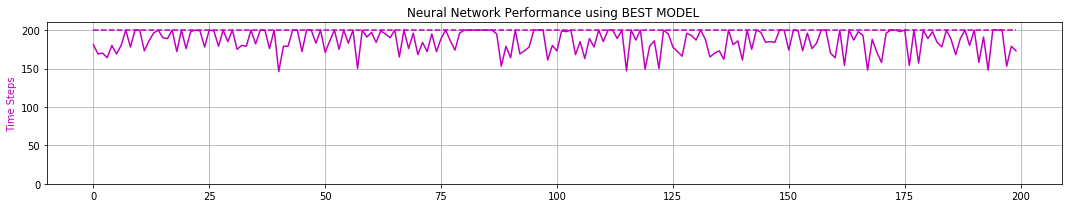

peak memory: 1462.94 MiB, increment: 1035.95 MiB
0 -max- [ 0.181  1.024  0.048  1.065]
0 -min- [-2.400 -3.176 -0.209 -1.462]

1 -max- [ 0.207  1.212  0.048  1.235]
1 -min- [-2.400 -3.167 -0.209 -1.749]

2 -max- [ 0.202  1.213  0.051  1.048]
2 -min- [-2.399 -3.256 -0.209 -1.684]

3 -max- [ 0.204  1.208  0.049  0.959]
3 -min- [-2.399 -3.169 -0.209 -1.717]

4 -max- [ 0.195  1.205  0.050  1.145]
4 -min- [-2.397 -3.350 -0.209 -1.770]

5 -max- [ 0.200  1.207  0.050  1.174]
5 -min- [-2.399 -3.258 -0.209 -1.755]

6 -max- [ 0.194  1.186  0.049  1.168]
6 -min- [-2.400 -3.168 -0.209 -1.743]

7 -max- [ 0.181  1.150  0.050  1.184]
7 -min- [-2.400 -3.171 -0.209 -1.727]

8 -max- [ 0.198  1.218  0.050  1.145]
8 -min- [-2.398 -3.164 -0.209 -1.745]

9 -max- [ 0.187  1.173  0.050  1.223]
9 -min- [-2.400 -3.157 -0.209 -1.702]

Quantization TIME:  0.02 minutes


ITERATION # 14
TOTAL EXPERIENCE GENERATED:   150816
SMALLEST TIMESTEP: 108
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1573747
TOTAL PARALLEL

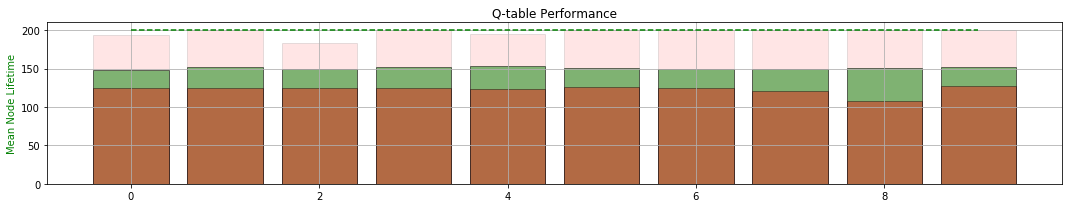

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 63.318	LOSS : 59.824	LOSS : 61.206	LOSS : 58.316	LOSS : 54.054	LOSS : 59.430	LOSS : 56.615	LOSS : 67.201	
Validating... MEAN TIME:  186.055
LOSS : 65.305	LOSS : 69.284	LOSS : 63.196	LOSS : 69.881	LOSS : 57.961	LOSS : 70.331	LOSS : 72.351	LOSS : 70.181	
Validating... MEAN TIME:  131.41
LOSS : 65.588	LOSS : 60.718	LOSS : 65.175	LOSS : 64.614	LOSS : 62.582	LOSS : 67.748	LOSS : 55.831	LOSS : 58.650	
Validating... MEAN TIME:  143.63
LOSS : 67.116	LOSS : 56.786	LOSS : 68.488	LOSS : 63.623	LOSS : 65.647	LOSS : 62.769	LOSS : 59.179	LOSS : 62.424	
Validating... MEAN TIME:  114.845
LOSS : 61.632	LOSS : 70.896	LOSS : 74.906	LOSS : 65.829	LOSS : 64.481	LOSS : 56.052	LOSS : 71.406	LOSS : 62.573	
Validating... MEAN TIME:  170.49
TRAINING TIME:0:00:56.443949


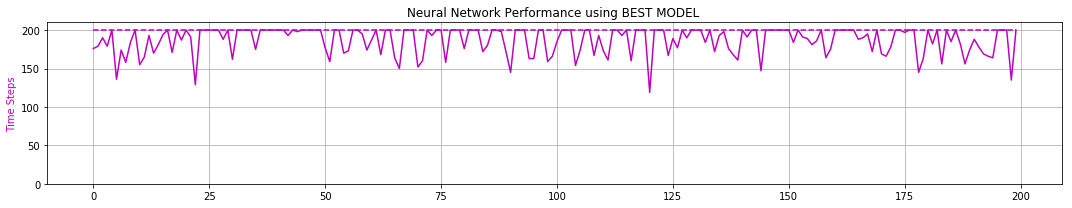

peak memory: 1464.50 MiB, increment: 977.66 MiB
0 -max- [ 0.778  1.294  0.202  1.004]
0 -min- [-1.882 -2.234 -0.209 -0.911]

1 -max- [ 0.829  1.422  0.204  0.763]
1 -min- [-1.907 -2.205 -0.209 -0.863]

2 -max- [ 0.121  0.630  0.049  0.705]
2 -min- [-1.861 -2.227 -0.209 -1.180]

3 -max- [ 0.124  0.570  0.050  0.728]
3 -min- [-1.858 -2.146 -0.209 -0.934]

4 -max- [ 0.149  0.575  0.050  0.874]
4 -min- [-1.860 -2.225 -0.209 -0.863]

5 -max- [ 0.823  1.468  0.207  1.011]
5 -min- [-1.948 -2.403 -0.209 -0.881]

6 -max- [ 0.180  0.577  0.050  0.714]
6 -min- [-1.909 -2.371 -0.209 -0.877]

7 -max- [ 0.205  0.584  0.050  0.608]
7 -min- [-1.847 -2.166 -0.209 -0.880]

8 -max- [ 0.792  1.300  0.207  0.740]
8 -min- [-1.859 -2.179 -0.209 -0.881]

9 -max- [ 0.181  0.612  0.048  0.696]
9 -min- [-1.941 -2.245 -0.209 -0.862]

Quantization TIME:  0.02 minutes


ITERATION # 15
TOTAL EXPERIENCE GENERATED:   177482
SMALLEST TIMESTEP: 91
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1751229
TOTAL PARALLEL T

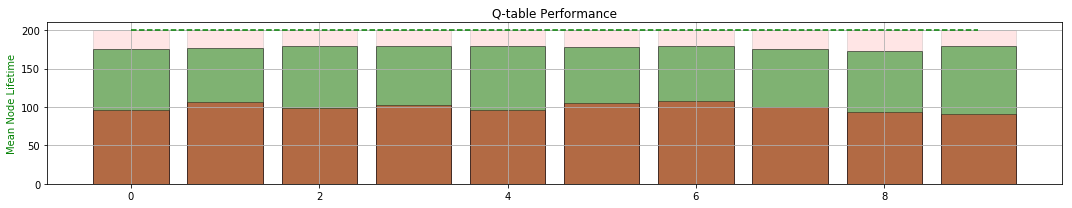

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 44.731	LOSS : 42.069	LOSS : 51.566	LOSS : 52.271	LOSS : 48.596	LOSS : 50.594	LOSS : 49.322	LOSS : 47.465	
Validating... MEAN TIME:  191.29
LOSS : 55.487	LOSS : 47.446	LOSS : 48.973	LOSS : 49.050	LOSS : 52.129	LOSS : 43.179	LOSS : 51.240	LOSS : 38.391	
Validating... MEAN TIME:  189.775
LOSS : 51.203	LOSS : 61.484	LOSS : 43.262	LOSS : 47.220	LOSS : 46.421	LOSS : 40.914	LOSS : 46.292	LOSS : 54.839	
Validating... MEAN TIME:  105.935
LOSS : 44.670	LOSS : 49.857	LOSS : 44.071	LOSS : 49.180	LOSS : 46.374	LOSS : 45.924	LOSS : 53.673	LOSS : 50.322	
Validating... MEAN TIME:  68.19
LOSS : 44.629	LOSS : 49.448	LOSS : 51.140	LOSS : 46.412	LOSS : 50.282	LOSS : 47.531	LOSS : 60.118	LOSS : 49.256	
Validating... MEAN TIME:  159.295
TRAINING TIME:0:00:56.316903


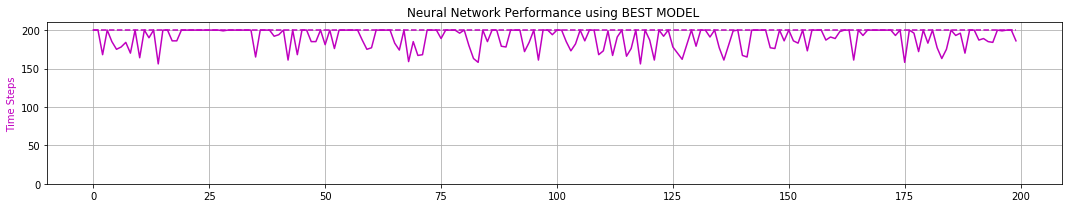

peak memory: 1509.84 MiB, increment: 1074.30 MiB
0 -max- [ 0.985  1.698  0.209  1.032]
0 -min- [-2.259 -2.589 -0.209 -0.794]

1 -max- [ 0.910  1.452  0.209  1.064]
1 -min- [-2.400 -2.774 -0.209 -0.869]

2 -max- [ 0.986  1.624  0.208  0.957]
2 -min- [-2.383 -2.892 -0.209 -0.790]

3 -max- [ 0.955  1.674  0.209  0.820]
3 -min- [-2.389 -2.913 -0.209 -1.191]

4 -max- [ 0.959  1.657  0.209  0.828]
4 -min- [-2.357 -2.774 -0.209 -0.870]

5 -max- [ 0.975  1.697  0.209  0.752]
5 -min- [-2.349 -2.758 -0.209 -0.784]

6 -max- [ 0.896  1.449  0.209  0.888]
6 -min- [-2.397 -2.885 -0.209 -0.784]

7 -max- [ 0.976  1.678  0.209  1.075]
7 -min- [-2.394 -2.745 -0.209 -0.862]

8 -max- [ 0.972  1.695  0.209  1.008]
8 -min- [-2.254 -2.698 -0.209 -0.858]

9 -max- [ 0.969  1.683  0.208  0.793]
9 -min- [-2.310 -2.597 -0.209 -0.820]

Quantization TIME:  0.02 minutes


ITERATION # 16
TOTAL EXPERIENCE GENERATED:   183015
SMALLEST TIMESTEP: 119
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1934244
TOTAL PARALLEL

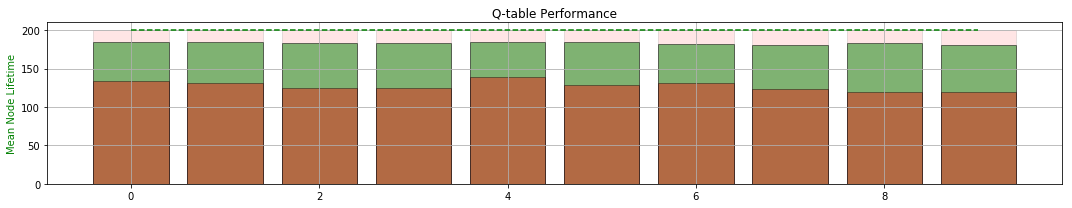

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 44.079	LOSS : 47.641	LOSS : 43.915	LOSS : 46.606	LOSS : 54.293	LOSS : 49.130	LOSS : 60.825	LOSS : 49.492	
Validating... MEAN TIME:  189.985
LOSS : 46.066	LOSS : 42.212	LOSS : 48.351	LOSS : 49.458	LOSS : 58.543	LOSS : 51.211	LOSS : 49.814	LOSS : 48.293	
Validating... MEAN TIME:  178.505
LOSS : 64.548	LOSS : 55.626	LOSS : 55.292	LOSS : 54.005	LOSS : 52.374	LOSS : 47.791	LOSS : 47.446	LOSS : 51.478	
Validating... MEAN TIME:  184.24
LOSS : 58.402	LOSS : 51.377	LOSS : 55.759	LOSS : 50.824	LOSS : 53.996	LOSS : 64.111	LOSS : 48.325	LOSS : 56.999	
Validating... MEAN TIME:  189.885
LOSS : 42.470	LOSS : 52.974	LOSS : 52.784	LOSS : 55.137	LOSS : 57.790	LOSS : 58.118	LOSS : 54.048	LOSS : 59.358	
Validating... MEAN TIME:  164.725
TRAINING TIME:0:01:01.695098


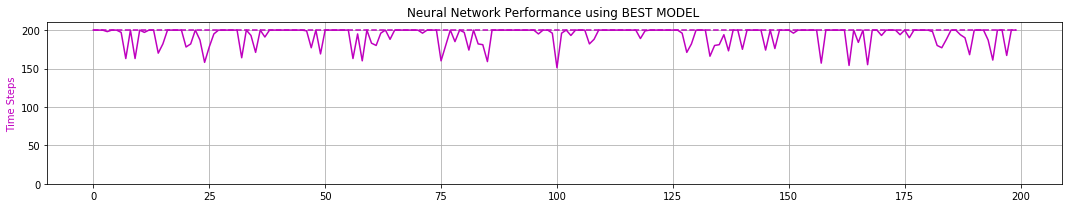

peak memory: 1495.49 MiB, increment: 999.84 MiB
0 -max- [ 1.051  1.816  0.208  1.058]
0 -min- [-2.230 -2.422 -0.209 -1.111]

1 -max- [ 1.128  1.862  0.209  1.001]
1 -min- [-2.261 -2.428 -0.209 -0.887]

2 -max- [ 1.091  1.865  0.209  1.115]
2 -min- [-2.211 -2.423 -0.209 -0.928]

3 -max- [ 1.118  1.880  0.209  1.112]
3 -min- [-2.395 -2.762 -0.209 -0.979]

4 -max- [ 1.107  1.823  0.208  1.006]
4 -min- [-2.246 -2.428 -0.209 -1.054]

5 -max- [ 1.093  1.833  0.208  0.865]
5 -min- [-2.389 -2.741 -0.209 -0.896]

6 -max- [ 1.112  1.864  0.209  1.069]
6 -min- [-2.392 -2.755 -0.209 -0.881]

7 -max- [ 1.122  1.685  0.208  0.954]
7 -min- [-2.349 -2.754 -0.209 -0.900]

8 -max- [ 1.132  1.861  0.209  1.455]
8 -min- [-2.397 -2.745 -0.209 -1.094]

9 -max- [ 1.196  2.032  0.209  1.066]
9 -min- [-2.386 -2.745 -0.209 -1.096]

Quantization TIME:  0.02 minutes


ITERATION # 17
TOTAL EXPERIENCE GENERATED:   180614
SMALLEST TIMESTEP: 112
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   2114858
TOTAL PARALLEL 

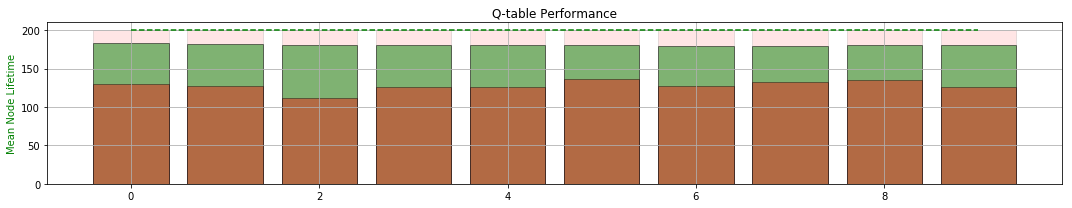

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 56.769	LOSS : 78.850	LOSS : 96.542	LOSS : 83.836	LOSS : 91.782	LOSS : 85.936	LOSS : 92.847	LOSS : 101.671	
Validating... MEAN TIME:  178.615
LOSS : 86.977	LOSS : 80.549	LOSS : 80.605	LOSS : 73.222	LOSS : 81.870	LOSS : 90.298	LOSS : 81.555	LOSS : 75.185	
Validating... MEAN TIME:  173.715
LOSS : 84.543	LOSS : 102.825	LOSS : 97.734	LOSS : 89.398	LOSS : 95.159	LOSS : 96.811	LOSS : 102.206	LOSS : 98.903	
Validating... MEAN TIME:  175.905
LOSS : 78.777	LOSS : 69.013	LOSS : 84.701	LOSS : 82.069	LOSS : 80.110	LOSS : 73.950	LOSS : 78.693	LOSS : 82.086	
Validating... MEAN TIME:  169.85
LOSS : 78.888	LOSS : 83.864	LOSS : 92.526	LOSS : 79.954	LOSS : 66.743	LOSS : 68.490	LOSS : 74.565	LOSS : 75.404	
Validating... MEAN TIME:  172.07
TRAINING TIME:0:01:00.850865


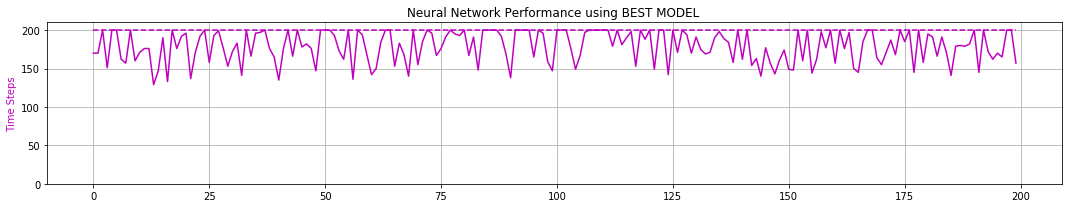

peak memory: 1487.27 MiB, increment: 1015.98 MiB
0 -max- [ 1.900  2.640  0.208  1.805]
0 -min- [-2.398 -3.731 -0.209 -1.226]

1 -max- [ 2.230  2.634  0.208  1.623]
1 -min- [-2.399 -3.564 -0.208 -1.177]

2 -max- [ 1.954  2.643  0.208  1.737]
2 -min- [-2.399 -3.701 -0.209 -1.232]

3 -max- [ 2.177  2.425  0.207  1.627]
3 -min- [-2.400 -3.570 -0.209 -1.295]

4 -max- [ 2.214  2.642  0.209  1.611]
4 -min- [-2.399 -3.573 -0.209 -1.098]

5 -max- [ 1.867  2.633  0.209  1.618]
5 -min- [-2.395 -3.570 -0.209 -1.093]

6 -max- [ 2.189  2.642  0.209  1.634]
6 -min- [-2.400 -3.575 -0.209 -1.115]

7 -max- [ 1.756  2.448  0.209  1.597]
7 -min- [-2.399 -3.566 -0.209 -1.265]

8 -max- [ 2.113  2.641  0.209  1.597]
8 -min- [-2.399 -3.561 -0.209 -1.349]

9 -max- [ 2.087  2.620  0.208  1.634]
9 -min- [-2.398 -3.579 -0.209 -1.378]

Quantization TIME:  0.02 minutes


ITERATION # 18
TOTAL EXPERIENCE GENERATED:   132841
SMALLEST TIMESTEP: 84
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   2247699
TOTAL PARALLEL 

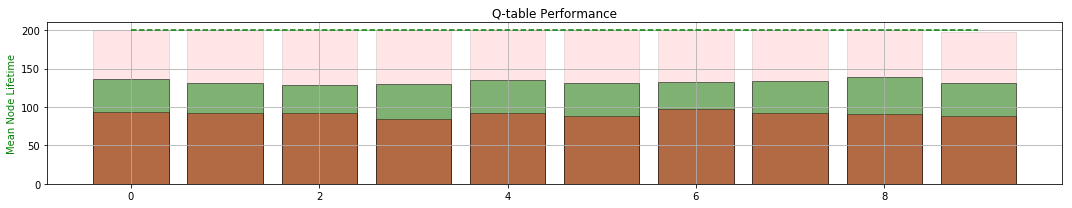

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 88.195	LOSS : 122.475	LOSS : 87.348	LOSS : 82.816	LOSS : 76.447	LOSS : 63.908	LOSS : 76.569	LOSS : 71.566	
Validating... MEAN TIME:  146.3
LOSS : 71.962	LOSS : 77.022	LOSS : 69.121	LOSS : 70.852	LOSS : 64.322	LOSS : 66.959	LOSS : 69.486	LOSS : 66.207	
Validating... MEAN TIME:  140.725
LOSS : 60.499	LOSS : 68.755	LOSS : 72.410	LOSS : 61.031	LOSS : 71.796	LOSS : 65.882	LOSS : 74.290	LOSS : 71.241	
Validating... MEAN TIME:  154.32
LOSS : 70.036	LOSS : 69.523	LOSS : 65.546	LOSS : 73.593	LOSS : 77.944	LOSS : 82.789	LOSS : 63.569	LOSS : 71.210	
Validating... MEAN TIME:  159.5
LOSS : 76.403	LOSS : 74.129	LOSS : 70.602	LOSS : 73.276	LOSS : 69.033	LOSS : 75.250	LOSS : 65.736	LOSS : 70.323	
Validating... MEAN TIME:  148.6
TRAINING TIME:0:00:54.842340


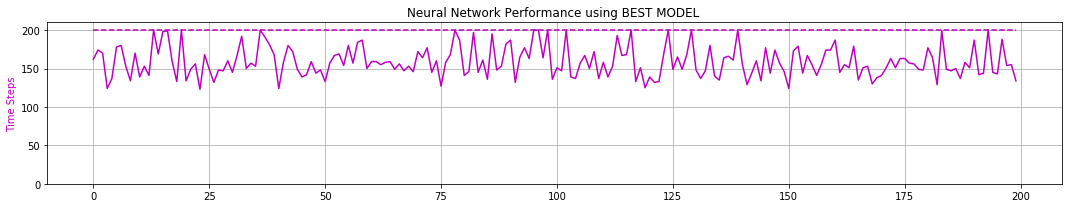

peak memory: 1495.49 MiB, increment: 1073.80 MiB
0 -max- [ 2.189  2.617  0.209  1.114]
0 -min- [-2.397 -3.537 -0.209 -1.018]

1 -max- [ 2.255  2.583  0.209  1.077]
1 -min- [-2.399 -3.365 -0.209 -1.055]

2 -max- [ 1.988  2.424  0.208  0.945]
2 -min- [-2.397 -3.358 -0.209 -1.121]

3 -max- [ 2.115  2.434  0.208  1.098]
3 -min- [-2.394 -3.518 -0.209 -0.824]

4 -max- [ 2.185  2.579  0.209  1.134]
4 -min- [-2.399 -3.527 -0.209 -0.996]

5 -max- [ 2.337  2.762  0.208  1.105]
5 -min- [-2.388 -3.365 -0.209 -0.830]

6 -max- [ 2.270  2.603  0.209  0.989]
6 -min- [-2.400 -3.364 -0.209 -0.945]

7 -max- [ 2.062  2.621  0.206  1.110]
7 -min- [-2.399 -3.451 -0.209 -1.089]

8 -max- [ 2.268  2.592  0.209  1.075]
8 -min- [-2.393 -3.368 -0.209 -0.919]

9 -max- [ 2.257  2.589  0.207  1.117]
9 -min- [-2.397 -3.516 -0.209 -1.346]

Quantization TIME:  0.02 minutes


ITERATION # 19
TOTAL EXPERIENCE GENERATED:   135321
SMALLEST TIMESTEP: 81
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   2383020
TOTAL PARALLEL 

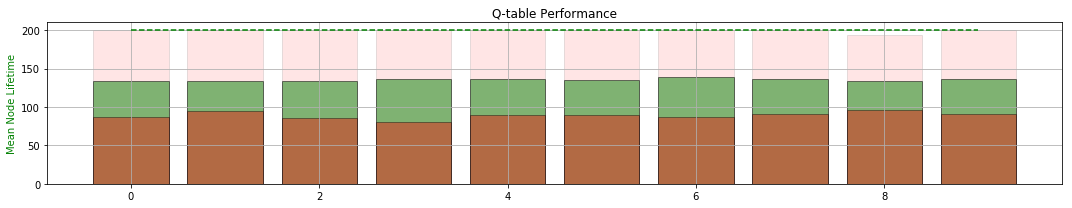

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 103.312	LOSS : 136.725	LOSS : 111.564	LOSS : 114.506	LOSS : 104.180	LOSS : 101.721	LOSS : 109.059	LOSS : 127.854	
Validating... MEAN TIME:  122.37
LOSS : 131.629	LOSS : 135.872	LOSS : 109.284	LOSS : 122.453	LOSS : 119.016	LOSS : 94.737	LOSS : 113.896	LOSS : 101.992	
Validating... MEAN TIME:  149.92
LOSS : 111.152	LOSS : 115.002	LOSS : 102.898	LOSS : 105.747	LOSS : 103.844	LOSS : 85.228	LOSS : 90.692	LOSS : 92.905	
Validating... MEAN TIME:  129.065
LOSS : 138.505	LOSS : 110.747	LOSS : 116.653	LOSS : 100.266	LOSS : 110.472	LOSS : 110.442	LOSS : 106.407	LOSS : 84.298	
Validating... MEAN TIME:  138.59
LOSS : 102.865	LOSS : 109.196	LOSS : 98.588	LOSS : 82.488	LOSS : 104.176	LOSS : 93.132	LOSS : 120.669	LOSS : 103.355	
Validating... MEAN TIME:  132.31
TRAINING TIME:0:00:53.212745


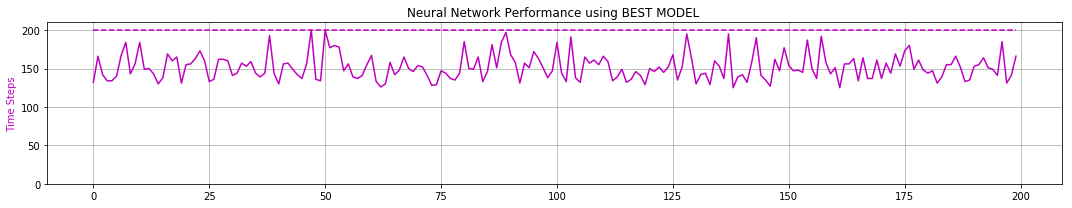

peak memory: 1514.94 MiB, increment: 1060.30 MiB
0 -max- [ 0.628  1.394  0.049  1.362]
0 -min- [-2.400 -3.676 -0.209 -1.922]

1 -max- [ 0.140  0.617  0.050  1.400]
1 -min- [-2.399 -3.697 -0.209 -0.918]

2 -max- [ 0.205  0.437  0.050  1.386]
2 -min- [-2.400 -3.688 -0.209 -0.819]

3 -max- [ 0.139  0.436  0.050  1.386]
3 -min- [-2.400 -3.671 -0.209 -0.808]

4 -max- [ 0.210  0.437  0.048  1.375]
4 -min- [-2.398 -3.697 -0.209 -1.068]

5 -max- [ 0.201  0.435  0.050  1.343]
5 -min- [-2.399 -3.663 -0.209 -1.043]

6 -max- [ 0.185  0.437  0.050  1.435]
6 -min- [-2.400 -3.698 -0.209 -1.045]

7 -max- [ 0.141  0.603  0.049  1.390]
7 -min- [-2.400 -3.679 -0.209 -0.889]

8 -max- [ 0.134  0.608  0.049  1.389]
8 -min- [-2.400 -3.725 -0.209 -1.086]

9 -max- [ 0.172  0.607  0.048  1.456]
9 -min- [-2.399 -3.722 -0.209 -0.820]

Quantization TIME:  0.02 minutes


ITERATION # 20
TOTAL EXPERIENCE GENERATED:   103631
SMALLEST TIMESTEP: 78
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   2486651
TOTAL PARALLEL 

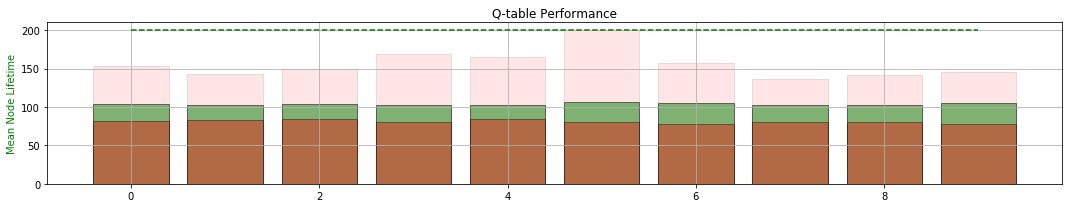

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 107.704	LOSS : 122.003	LOSS : 110.533	LOSS : 102.130	LOSS : 103.404	LOSS : 103.258	LOSS : 93.609	LOSS : 93.543	
Validating... MEAN TIME:  129.895
LOSS : 102.533	LOSS : 82.420	LOSS : 90.622	LOSS : 85.985	LOSS : 106.432	LOSS : 109.990	LOSS : 99.269	LOSS : 103.211	
Validating... MEAN TIME:  129.51
LOSS : 92.032	LOSS : 108.976	LOSS : 105.354	LOSS : 113.497	LOSS : 98.291	LOSS : 105.227	LOSS : 87.760	LOSS : 84.155	
Validating... MEAN TIME:  131.91
LOSS : 90.626	LOSS : 109.271	LOSS : 119.596	LOSS : 111.081	LOSS : 104.220	LOSS : 103.312	LOSS : 94.735	LOSS : 100.628	
Validating... MEAN TIME:  125.67
LOSS : 94.808	LOSS : 105.476	LOSS : 105.683	LOSS : 97.644	LOSS : 96.959	LOSS : 108.893	LOSS : 110.091	LOSS : 100.583	
Validating... MEAN TIME:  132.355
TRAINING TIME:0:00:51.594908


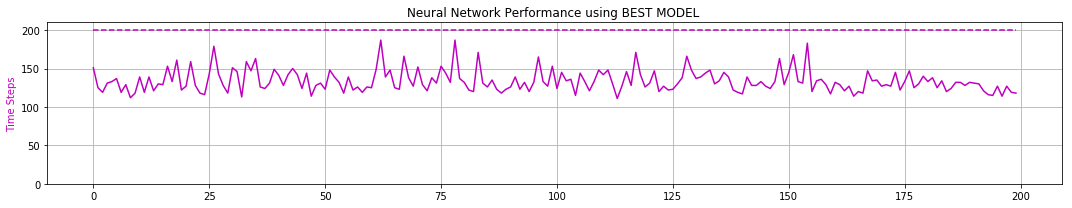

peak memory: 1477.55 MiB, increment: 978.19 MiB
0 -max- [ 0.109  0.630  0.050  0.699]
0 -min- [-2.377 -3.267 -0.209 -1.039]

1 -max- [ 0.117  0.627  0.050  0.664]
1 -min- [-2.386 -3.267 -0.209 -1.150]

2 -max- [ 0.107  0.631  0.050  0.829]
2 -min- [-2.399 -3.502 -0.209 -0.881]

3 -max- [ 0.130  0.629  0.048  0.668]
3 -min- [-2.147 -2.902 -0.209 -0.859]

4 -max- [ 0.137  0.629  0.050  0.713]
4 -min- [-2.340 -3.076 -0.209 -0.884]

5 -max- [ 0.196  0.631  0.050  0.675]
5 -min- [-2.395 -3.291 -0.209 -1.087]

6 -max- [ 0.116  0.630  0.049  0.593]
6 -min- [-2.132 -2.904 -0.209 -0.881]

7 -max- [ 0.108  0.750  0.049  0.946]
7 -min- [-2.357 -3.092 -0.209 -1.098]

8 -max- [ 0.117  0.625  0.048  0.681]
8 -min- [-2.145 -2.785 -0.209 -0.882]

9 -max- [ 0.136  0.739  0.050  0.819]
9 -min- [-2.392 -3.162 -0.209 -1.122]

Quantization TIME:  0.02 minutes


ITERATION # 21
TOTAL EXPERIENCE GENERATED:   107020
SMALLEST TIMESTEP: 67
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   2593671
TOTAL PARALLEL T

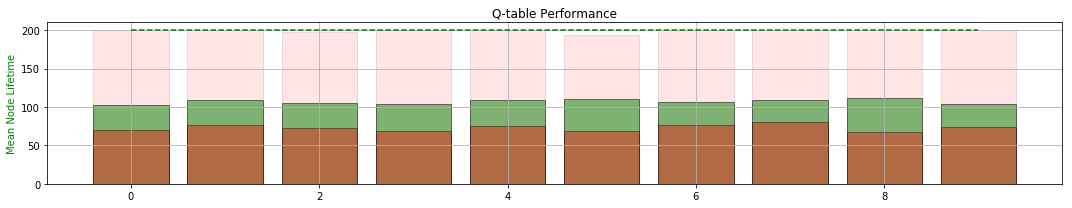

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 87.321	LOSS : 77.311	LOSS : 88.688	LOSS : 87.663	LOSS : 78.713	LOSS : 92.130	LOSS : 80.798	LOSS : 84.653	
Validating... MEAN TIME:  129.515
LOSS : 77.254	LOSS : 79.953	LOSS : 75.997	LOSS : 84.201	LOSS : 85.490	LOSS : 83.148	LOSS : 82.519	LOSS : 85.865	
Validating... MEAN TIME:  136.86
LOSS : 82.563	LOSS : 85.826	LOSS : 92.289	LOSS : 74.140	LOSS : 83.641	LOSS : 88.682	LOSS : 80.150	LOSS : 79.588	
Validating... MEAN TIME:  130.215
LOSS : 82.666	LOSS : 84.774	LOSS : 90.154	LOSS : 84.985	LOSS : 77.258	LOSS : 89.285	LOSS : 89.884	LOSS : 97.077	
Validating... MEAN TIME:  137.505
LOSS : 93.809	LOSS : 90.240	LOSS : 90.394	LOSS : 99.034	LOSS : 90.734	LOSS : 93.746	LOSS : 101.614	LOSS : 97.054	
Validating... MEAN TIME:  132.4
TRAINING TIME:0:00:52.768439


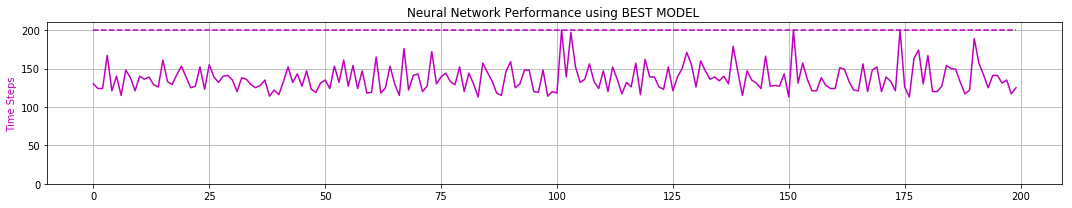

peak memory: 1477.68 MiB, increment: 1017.13 MiB
0 -max- [ 2.373  2.952  0.199  0.643]
0 -min- [-1.809 -2.430 -0.209 -0.936]

1 -max- [ 2.396  2.969  0.209  0.771]
1 -min- [-2.362 -3.340 -0.209 -0.881]

2 -max- [ 2.391  3.147  0.209  0.729]
2 -min- [-1.960 -2.714 -0.209 -0.862]

3 -max- [ 2.380  2.968  0.209  0.644]
3 -min- [-2.019 -2.776 -0.209 -1.049]

4 -max- [ 2.383  3.140  0.208  0.823]
4 -min- [-2.358 -3.324 -0.209 -1.100]

5 -max- [ 2.388  2.961  0.208  0.800]
5 -min- [-2.394 -3.439 -0.209 -0.880]

6 -max- [ 2.374  2.753  0.209  0.789]
6 -min- [-2.384 -3.339 -0.209 -1.143]

7 -max- [ 2.394  2.752  0.208  0.783]
7 -min- [-2.356 -3.264 -0.209 -1.120]

8 -max- [ 2.397  2.902  0.204  0.685]
8 -min- [-2.361 -3.257 -0.209 -0.907]

9 -max- [ 2.369  2.775  0.207  0.791]
9 -min- [-2.070 -2.940 -0.209 -0.879]

Quantization TIME:  0.02 minutes


ITERATION # 22
TOTAL EXPERIENCE GENERATED:   106204
SMALLEST TIMESTEP: 66
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   2699875
TOTAL PARALLEL 

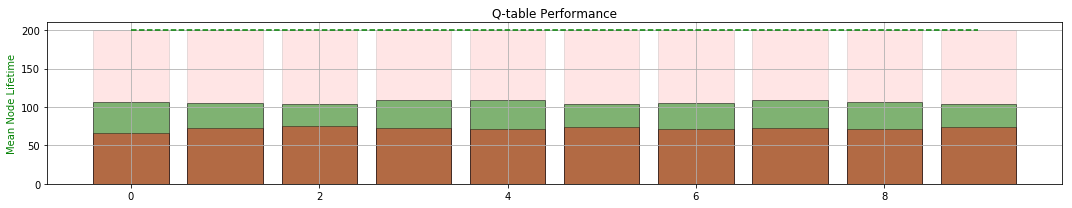

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 80.454	LOSS : 93.114	LOSS : 85.546	LOSS : 89.436	LOSS : 81.033	LOSS : 88.310	LOSS : 96.546	LOSS : 92.114	
Validating... MEAN TIME:  140.65
LOSS : 87.772	LOSS : 94.808	LOSS : 88.122	LOSS : 86.841	LOSS : 87.606	LOSS : 85.589	LOSS : 85.348	LOSS : 80.807	
Validating... MEAN TIME:  133.095
LOSS : 85.658	LOSS : 91.301	LOSS : 82.792	LOSS : 84.767	LOSS : 86.998	LOSS : 84.159	LOSS : 88.676	LOSS : 78.663	
Validating... MEAN TIME:  128.22
LOSS : 73.310	LOSS : 80.753	LOSS : 80.732	LOSS : 82.903	LOSS : 77.135	LOSS : 88.257	LOSS : 85.530	LOSS : 84.066	
Validating... MEAN TIME:  142.745
LOSS : 77.236	LOSS : 80.504	LOSS : 80.166	LOSS : 75.582	LOSS : 66.320	LOSS : 76.696	LOSS : 78.362	LOSS : 81.972	
Validating... MEAN TIME:  154.175
TRAINING TIME:0:00:52.995995


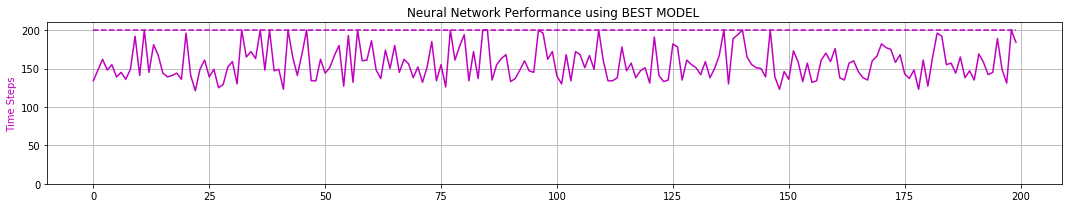

peak memory: 1497.88 MiB, increment: 1017.01 MiB
0 -max- [ 0.959  1.659  0.207  0.822]
0 -min- [-1.729 -2.589 -0.209 -0.956]

1 -max- [ 0.995  1.682  0.207  0.848]
1 -min- [-1.689 -2.425 -0.209 -1.067]

2 -max- [ 0.750  1.120  0.208  0.729]
2 -min- [-1.904 -2.698 -0.209 -1.022]

3 -max- [ 0.972  1.701  0.209  0.783]
3 -min- [-1.767 -2.545 -0.209 -1.106]

4 -max- [ 0.985  1.680  0.209  0.776]
4 -min- [-1.927 -2.716 -0.209 -1.066]

5 -max- [ 0.213  0.574  0.049  0.723]
5 -min- [-1.865 -2.696 -0.209 -1.161]

6 -max- [ 0.736  1.091  0.206  0.724]
6 -min- [-1.881 -2.719 -0.209 -0.991]

7 -max- [ 0.759  1.106  0.209  0.710]
7 -min- [-1.855 -2.700 -0.209 -1.089]

8 -max- [ 0.890  1.500  0.207  0.804]
8 -min- [-1.863 -2.696 -0.209 -1.082]

9 -max- [ 0.147  0.573  0.050  0.667]
9 -min- [-1.776 -2.534 -0.209 -0.882]

Quantization TIME:  0.02 minutes


ITERATION # 23
TOTAL EXPERIENCE GENERATED:   145645
SMALLEST TIMESTEP: 84
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   2845520
TOTAL PARALLEL 

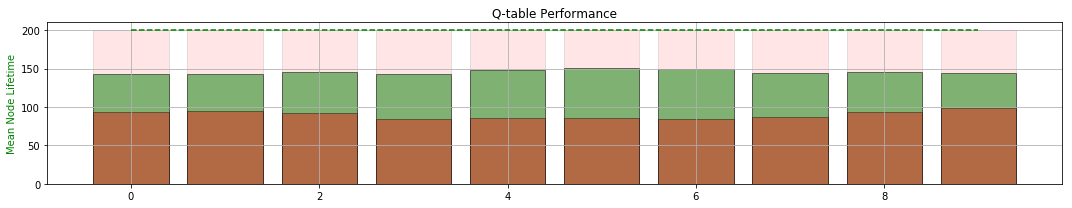

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 64.530	LOSS : 53.397	LOSS : 58.522	LOSS : 65.024	LOSS : 60.717	LOSS : 57.372	LOSS : 64.908	LOSS : 67.197	
Validating... MEAN TIME:  187.19
LOSS : 58.360	LOSS : 58.489	LOSS : 62.167	LOSS : 61.046	LOSS : 61.005	LOSS : 64.757	LOSS : 63.082	LOSS : 62.316	
Validating... MEAN TIME:  160.675
LOSS : 64.674	LOSS : 56.934	LOSS : 61.511	LOSS : 65.997	LOSS : 62.078	LOSS : 65.271	LOSS : 65.943	LOSS : 72.031	
Validating... MEAN TIME:  141.74
LOSS : 78.378	LOSS : 67.609	LOSS : 73.045	LOSS : 63.395	LOSS : 58.348	LOSS : 66.331	LOSS : 58.607	LOSS : 64.502	
Validating... MEAN TIME:  145.77
LOSS : 62.285	LOSS : 58.575	LOSS : 63.242	LOSS : 65.576	LOSS : 63.840	LOSS : 61.801	LOSS : 73.566	LOSS : 60.481	
Validating... MEAN TIME:  138.7
TRAINING TIME:0:00:55.985231


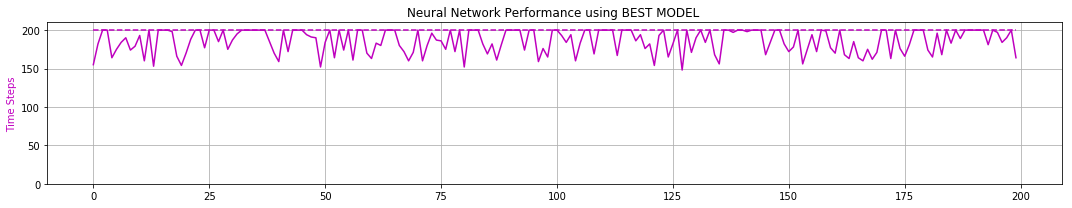

peak memory: 1482.18 MiB, increment: 977.82 MiB
0 -max- [ 1.334  1.878  0.209  0.882]
0 -min- [-1.871 -2.589 -0.209 -1.036]

1 -max- [ 1.335  2.057  0.209  0.854]
1 -min- [-2.182 -2.697 -0.209 -1.021]

2 -max- [ 1.260  1.881  0.209  1.107]
2 -min- [-1.626 -2.378 -0.209 -1.067]

3 -max- [ 1.310  2.058  0.209  1.003]
3 -min- [-1.943 -2.720 -0.209 -1.103]

4 -max- [ 1.271  1.878  0.209  0.874]
4 -min- [-1.856 -2.546 -0.209 -0.995]

5 -max- [ 1.311  2.055  0.209  0.855]
5 -min- [-2.202 -2.889 -0.209 -1.124]

6 -max- [ 1.265  1.874  0.209  0.906]
6 -min- [-1.796 -2.557 -0.209 -0.958]

7 -max- [ 1.244  1.876  0.208  0.879]
7 -min- [-1.796 -2.554 -0.209 -0.999]

8 -max- [ 1.308  1.888  0.209  0.851]
8 -min- [-1.829 -2.556 -0.209 -1.058]

9 -max- [ 1.329  2.053  0.208  1.081]
9 -min- [-1.956 -2.732 -0.209 -1.068]

Quantization TIME:  0.02 minutes


ITERATION # 24
TOTAL EXPERIENCE GENERATED:   172703
SMALLEST TIMESTEP: 111
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   3018223
TOTAL PARALLEL 

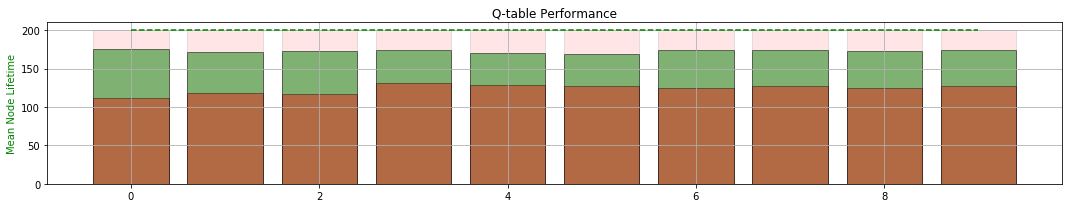

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 97.958	LOSS : 89.823	LOSS : 101.976	LOSS : 97.652	LOSS : 93.311	LOSS : 98.582	LOSS : 89.125	LOSS : 94.605	
Validating... MEAN TIME:  182.745
LOSS : 98.286	LOSS : 98.778	LOSS : 101.457	LOSS : 85.526	LOSS : 95.116	LOSS : 96.025	LOSS : 74.767	LOSS : 75.541	
Validating... MEAN TIME:  118.105
LOSS : 67.313	LOSS : 78.012	LOSS : 89.569	LOSS : 82.973	LOSS : 88.014	LOSS : 77.778	LOSS : 81.785	LOSS : 84.777	
Validating... MEAN TIME:  111.88
LOSS : 84.840	LOSS : 80.970	LOSS : 89.320	LOSS : 71.066	LOSS : 78.610	LOSS : 70.300	LOSS : 56.446	LOSS : 61.447	
Validating... MEAN TIME:  117.48
LOSS : 57.341	LOSS : 67.963	LOSS : 65.498	LOSS : 63.230	LOSS : 59.635	LOSS : 63.072	LOSS : 56.724	LOSS : 59.524	
Validating... MEAN TIME:  179.215
TRAINING TIME:0:00:56.018475


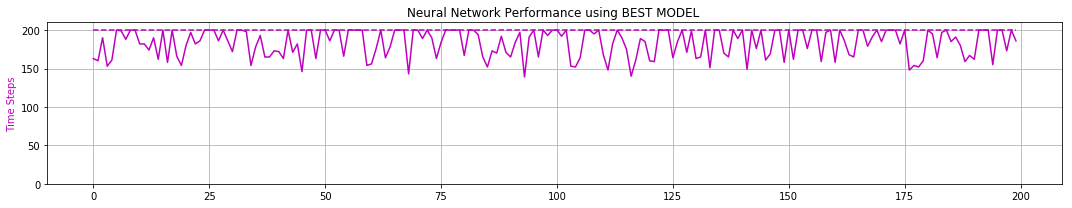

peak memory: 1529.75 MiB, increment: 1073.91 MiB
0 -max- [ 1.329  2.432  0.208  2.573]
0 -min- [-2.357 -3.161 -0.209 -2.301]

1 -max- [ 1.363  2.305  0.209  2.803]
1 -min- [-2.372 -3.351 -0.209 -2.272]

2 -max- [ 1.314  2.296  0.204  2.699]
2 -min- [-2.360 -3.160 -0.209 -2.071]

3 -max- [ 1.293  2.426  0.206  2.643]
3 -min- [-2.398 -3.338 -0.209 -2.281]

4 -max- [ 1.388  2.265  0.208  2.628]
4 -min- [-2.338 -3.142 -0.209 -2.060]

5 -max- [ 1.315  2.639  0.208  2.590]
5 -min- [-2.350 -3.172 -0.209 -2.244]

6 -max- [ 1.301  2.426  0.209  2.589]
6 -min- [-0.169 -1.398 -0.209 -2.260]

7 -max- [ 1.284  2.292  0.208  2.629]
7 -min- [-0.707 -1.404 -0.209 -2.159]

8 -max- [ 1.302  2.306  0.205  2.599]
8 -min- [-0.118 -1.419 -0.209 -2.127]

9 -max- [ 1.330  2.252  0.209  2.869]
9 -min- [-1.972 -2.412 -0.209 -2.055]

Quantization TIME:  0.02 minutes


ITERATION # 25
TOTAL EXPERIENCE GENERATED:   165934
SMALLEST TIMESTEP: 94
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   3184157
TOTAL PARALLEL 

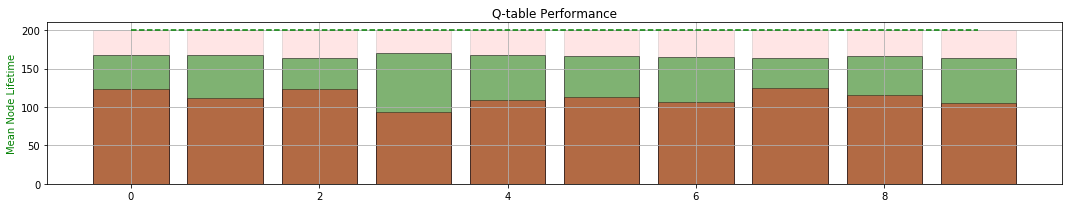

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 69.889	LOSS : 81.282	LOSS : 88.086	LOSS : 74.272	LOSS : 61.554	LOSS : 65.254	LOSS : 69.780	LOSS : 75.198	
Validating... MEAN TIME:  135.755
LOSS : 71.531	LOSS : 60.003	LOSS : 72.724	LOSS : 76.012	LOSS : 68.581	LOSS : 65.523	LOSS : 55.710	LOSS : 59.909	
Validating... MEAN TIME:  35.98
LOSS : 57.567	LOSS : 55.271	LOSS : 67.354	LOSS : 57.095	LOSS : 67.238	LOSS : 58.251	LOSS : 59.487	LOSS : 65.923	
Validating... MEAN TIME:  90.64
LOSS : 60.635	LOSS : 53.585	LOSS : 57.077	LOSS : 74.813	LOSS : 62.344	LOSS : 52.867	LOSS : 60.843	LOSS : 50.284	
Validating... MEAN TIME:  30.735
LOSS : 53.475	LOSS : 60.307	LOSS : 54.485	LOSS : 51.208	LOSS : 47.248	LOSS : 60.665	LOSS : 66.934	LOSS : 42.272	
Validating... MEAN TIME:  14.89
TRAINING TIME:0:00:38.936641


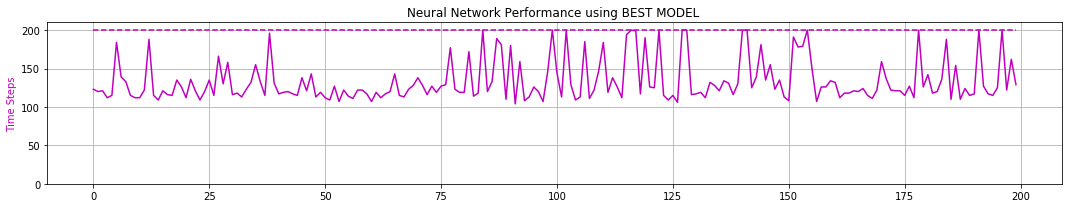

peak memory: 1492.01 MiB, increment: 977.84 MiB
0 -max- [ 2.333  2.464  0.200  1.643]
0 -min- [-2.399 -2.933 -0.209 -1.658]

1 -max- [ 1.436  2.292  0.140  1.891]
1 -min- [-2.393 -2.961 -0.209 -1.584]

2 -max- [ 0.997  1.647  0.121  1.359]
2 -min- [-2.399 -2.937 -0.209 -1.431]

3 -max- [ 1.285  1.869  0.146  1.360]
3 -min- [-2.394 -2.965 -0.209 -1.516]

4 -max- [ 1.776  1.914  0.195  1.623]
4 -min- [-2.389 -2.949 -0.209 -1.617]

5 -max- [ 1.799  1.902  0.205  1.332]
5 -min- [-2.388 -2.943 -0.209 -1.313]

6 -max- [ 0.947  1.725  0.140  1.485]
6 -min- [-2.396 -2.952 -0.209 -1.376]

7 -max- [ 2.373  2.668  0.192  1.546]
7 -min- [-2.399 -2.965 -0.209 -1.580]

8 -max- [ 1.862  2.641  0.193  1.677]
8 -min- [-2.400 -2.970 -0.209 -1.507]

9 -max- [ 1.356  2.101  0.154  1.486]
9 -min- [-2.392 -2.956 -0.209 -1.372]

Quantization TIME:  0.02 minutes


ITERATION # 26
TOTAL EXPERIENCE GENERATED:   132083
SMALLEST TIMESTEP: 79
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   3316240
TOTAL PARALLEL T

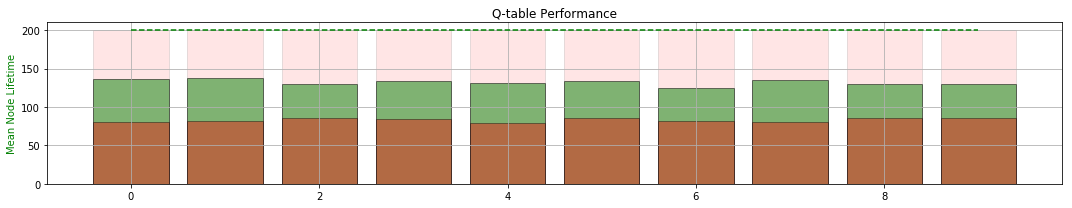

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 148.497	LOSS : 108.137	LOSS : 90.662	LOSS : 86.537	LOSS : 75.228	LOSS : 76.166	LOSS : 69.463	LOSS : 74.808	
Validating... MEAN TIME:  12.275
LOSS : 83.062	LOSS : 71.451	LOSS : 72.890	LOSS : 74.563	LOSS : 68.262	LOSS : 73.724	LOSS : 68.061	LOSS : 74.487	
Validating... MEAN TIME:  11.025
LOSS : 68.727	LOSS : 69.365	LOSS : 68.710	LOSS : 58.036	LOSS : 71.974	LOSS : 64.767	LOSS : 67.833	LOSS : 61.020	
Validating... MEAN TIME:  11.02
LOSS : 72.578	LOSS : 65.888	LOSS : 69.764	LOSS : 69.735	LOSS : 62.222	LOSS : 71.307	LOSS : 72.863	LOSS : 74.656	
Validating... MEAN TIME:  10.425
LOSS : 71.203	LOSS : 54.107	LOSS : 61.007	LOSS : 62.562	LOSS : 66.774	LOSS : 59.104	LOSS : 62.096	LOSS : 60.913	
Validating... MEAN TIME:  9.965
TRAINING TIME:0:00:32.624572


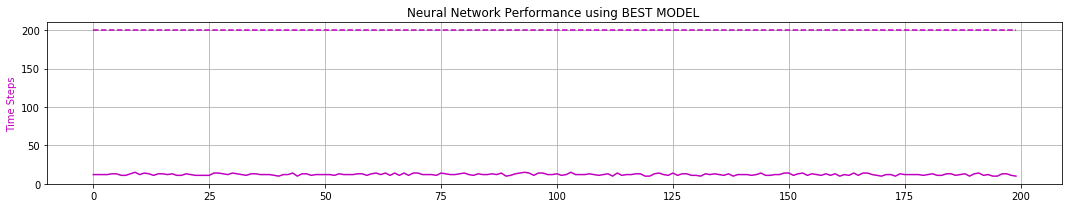

peak memory: 1511.54 MiB, increment: 977.71 MiB
0 -max- [ 1.849  2.865  0.166  1.192]
0 -min- [-2.351 -2.918 -0.209 -1.947]

1 -max- [ 1.821  2.860  0.181  1.202]
1 -min- [-2.141 -2.891 -0.209 -1.931]

2 -max- [ 1.654  2.768  0.172  1.193]
2 -min- [-2.370 -2.957 -0.209 -1.904]

3 -max- [ 1.839  2.789  0.184  1.465]
3 -min- [-2.353 -3.068 -0.209 -1.856]

4 -max- [ 1.803  2.798  0.176  1.503]
4 -min- [-2.167 -2.911 -0.209 -1.942]

5 -max- [ 1.822  2.806  0.182  1.203]
5 -min- [-2.267 -2.920 -0.209 -1.942]

6 -max- [ 1.764  2.862  0.170  1.198]
6 -min- [-2.129 -2.946 -0.209 -1.951]

7 -max- [ 1.871  2.798  0.167  1.194]
7 -min- [-2.347 -3.066 -0.209 -1.801]

8 -max- [ 1.918  2.820  0.206  1.187]
8 -min- [-2.281 -2.921 -0.209 -1.855]

9 -max- [ 1.885  2.855  0.165  1.205]
9 -min- [-2.323 -2.926 -0.209 -1.952]

Quantization TIME:  0.02 minutes


ITERATION # 27
TOTAL EXPERIENCE GENERATED:   14761
SMALLEST TIMESTEP: 9
LARGEST  TIMESTEP: 27
TOTAL SERIAL TIMESTEPS:   3331001
TOTAL PARALLEL TIME

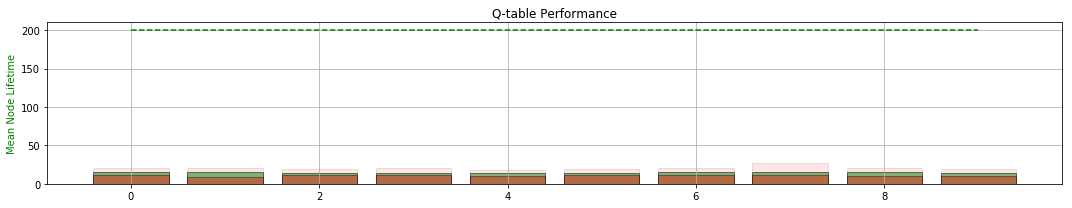

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 119.127	LOSS : 111.441	LOSS : 98.331	LOSS : 98.783	LOSS : 118.785	LOSS : 104.488	LOSS : 104.267	LOSS : 107.526	
Validating... MEAN TIME:  23.895
LOSS : 109.448	LOSS : 115.081	LOSS : 126.596	LOSS : 127.349	LOSS : 101.975	LOSS : 118.610	LOSS : 107.709	LOSS : 137.176	
Validating... MEAN TIME:  181.085
LOSS : 125.019	LOSS : 119.124	LOSS : 122.717	LOSS : 130.289	LOSS : 127.740	LOSS : 125.258	LOSS : 130.425	LOSS : 118.789	
Validating... MEAN TIME:  136.315
LOSS : 124.363	LOSS : 128.502	LOSS : 120.151	LOSS : 128.623	LOSS : 127.226	LOSS : 114.890	LOSS : 113.400	LOSS : 109.457	
Validating... MEAN TIME:  140.56
LOSS : 116.240	LOSS : 124.548	LOSS : 107.136	LOSS : 120.283	LOSS : 121.136	LOSS : 118.962	LOSS : 115.350	LOSS : 118.739	
Validating... MEAN TIME:  155.41
TRAINING TIME:0:00:54.281669


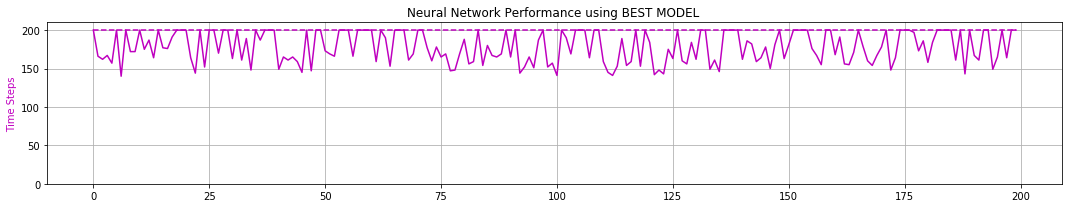

peak memory: 1444.50 MiB, increment: 1015.58 MiB
0 -max- [ 0.050  0.409  0.209  1.737]
0 -min- [-0.217 -1.205 -0.050 -0.314]

1 -max- [ 0.050  0.412  0.209  1.840]
1 -min- [-0.209 -1.187 -0.050 -0.298]

2 -max- [ 0.050  0.416  0.209  1.783]
2 -min- [-0.206 -1.216 -0.049 -0.601]

3 -max- [ 0.050  0.412  0.209  1.760]
3 -min- [-0.212 -1.209 -0.063 -0.567]

4 -max- [ 0.049  0.399  0.209  1.790]
4 -min- [-0.207 -1.204 -0.048 -0.063]

5 -max- [ 0.048  0.414  0.209  1.758]
5 -min- [-0.198 -1.211 -0.050 -0.343]

6 -max- [ 0.049  0.410  0.209  1.729]
6 -min- [-0.212 -1.214 -0.048 -0.067]

7 -max- [ 0.049  0.540  0.209  1.755]
7 -min- [-0.207 -1.206 -0.047 -0.420]

8 -max- [ 0.048  0.402  0.209  1.736]
8 -min- [-0.203 -1.218 -0.048 -0.072]

9 -max- [ 0.049  0.402  0.209  1.747]
9 -min- [-0.201 -1.219 -0.050 -0.294]

Quantization TIME:  0.02 minutes


ITERATION # 28
TOTAL EXPERIENCE GENERATED:   136090
SMALLEST TIMESTEP: 89
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   3467091
TOTAL PARALLEL 

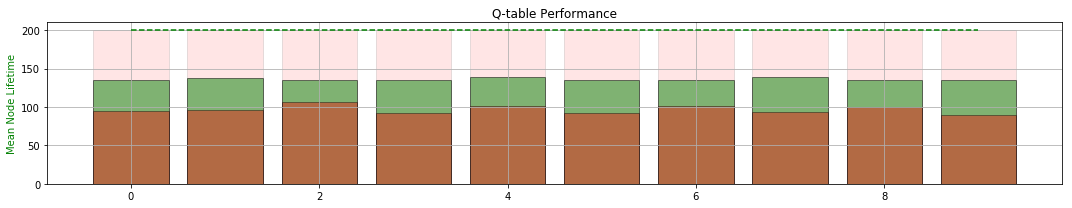

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 128.760	LOSS : 128.037	LOSS : 122.324	LOSS : 105.758	LOSS : 121.960	LOSS : 125.347	LOSS : 120.914	LOSS : 120.340	
Validating... MEAN TIME:  135.78
LOSS : 133.453	LOSS : 124.447	LOSS : 129.884	LOSS : 123.580	LOSS : 134.730	LOSS : 125.751	LOSS : 131.168	LOSS : 130.605	
Validating... MEAN TIME:  138.7
LOSS : 137.393	LOSS : 117.304	LOSS : 118.401	LOSS : 118.427	LOSS : 115.144	LOSS : 114.412	LOSS : 110.202	LOSS : 111.060	
Validating... MEAN TIME:  156.79
LOSS : 115.172	LOSS : 104.958	LOSS : 112.245	LOSS : 111.519	LOSS : 109.524	LOSS : 101.722	LOSS : 108.620	LOSS : 105.967	
Validating... MEAN TIME:  142.615
LOSS : 98.976	LOSS : 107.331	LOSS : 110.252	LOSS : 115.800	LOSS : 115.664	LOSS : 101.994	LOSS : 99.226	LOSS : 112.625	
Validating... MEAN TIME:  143.49
TRAINING TIME:0:00:56.769062


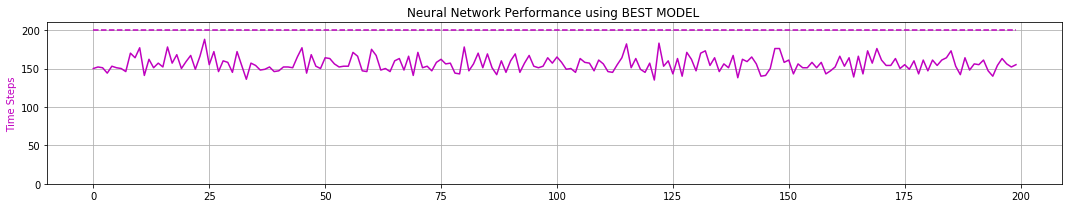

peak memory: 1488.92 MiB, increment: 1022.42 MiB
0 -max- [ 0.172  1.287  0.094  0.666]
0 -min- [-2.396 -2.955 -0.209 -0.990]

1 -max- [ 0.151  1.098  0.091  0.806]
1 -min- [-2.391 -3.074 -0.209 -0.996]

2 -max- [ 0.195  1.272  0.103  0.696]
2 -min- [-2.375 -3.070 -0.209 -0.989]

3 -max- [ 0.241  1.293  0.104  0.706]
3 -min- [-2.396 -2.954 -0.209 -1.256]

4 -max- [ 0.158  1.278  0.101  0.730]
4 -min- [-2.381 -2.949 -0.209 -1.027]

5 -max- [ 0.271  1.279  0.098  0.695]
5 -min- [-2.116 -2.745 -0.209 -0.963]

6 -max- [ 0.204  1.121  0.092  0.685]
6 -min- [-2.388 -3.074 -0.209 -1.045]

7 -max- [ 0.674  1.647  0.095  0.931]
7 -min- [-2.373 -3.081 -0.209 -0.880]

8 -max- [ 0.354  1.278  0.088  0.706]
8 -min- [-2.374 -3.072 -0.209 -0.918]

9 -max- [ 0.243  1.281  0.099  0.734]
9 -min- [-2.378 -3.076 -0.209 -1.006]

Quantization TIME:  0.02 minutes


ITERATION # 29
TOTAL EXPERIENCE GENERATED:   140600
SMALLEST TIMESTEP: 103
LARGEST  TIMESTEP: 172
TOTAL SERIAL TIMESTEPS:   3607691
TOTAL PARALLEL

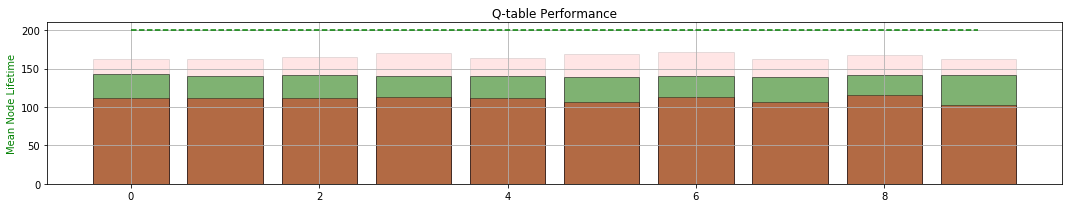

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 101.196	LOSS : 106.296	LOSS : 110.668	LOSS : 93.989	LOSS : 96.420	LOSS : 91.691	LOSS : 104.934	LOSS : 104.843	
Validating... MEAN TIME:  106.83
LOSS : 117.076	LOSS : 112.313	LOSS : 111.543	LOSS : 90.511	LOSS : 95.776	LOSS : 79.243	LOSS : 78.838	LOSS : 83.698	
Validating... MEAN TIME:  101.705
LOSS : 83.369	LOSS : 83.126	LOSS : 75.421	LOSS : 75.746	LOSS : 81.809	LOSS : 82.062	LOSS : 69.871	LOSS : 63.136	
Validating... MEAN TIME:  126.475
LOSS : 65.897	LOSS : 60.907	LOSS : 73.344	LOSS : 59.006	LOSS : 60.886	LOSS : 60.040	LOSS : 70.107	LOSS : 71.897	
Validating... MEAN TIME:  114.28
LOSS : 64.397	LOSS : 67.210	LOSS : 70.190	LOSS : 70.736	LOSS : 66.518	LOSS : 60.036	LOSS : 62.922	LOSS : 56.580	
Validating... MEAN TIME:  113.235
TRAINING TIME:0:00:50.094060


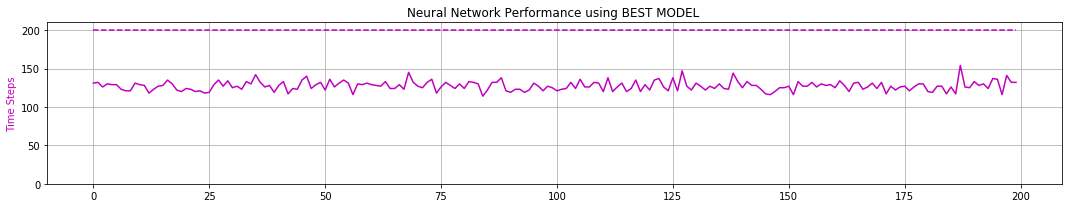

peak memory: 1489.67 MiB, increment: 1017.20 MiB
0 -max- [ 0.125  0.772  0.050  0.904]
0 -min- [-2.398 -3.359 -0.209 -1.121]

1 -max- [ 0.121  0.767  0.049  0.695]
1 -min- [-2.400 -3.160 -0.209 -1.074]

2 -max- [ 0.114  0.762  0.050  0.699]
2 -min- [-2.400 -3.254 -0.209 -1.297]

3 -max- [ 0.109  0.621  0.050  0.698]
3 -min- [-2.398 -3.167 -0.209 -1.018]

4 -max- [ 0.117  0.630  0.049  0.696]
4 -min- [-2.398 -3.167 -0.209 -0.900]

5 -max- [ 0.110  0.633  0.048  0.701]
5 -min- [-2.400 -3.170 -0.209 -0.903]

6 -max- [ 0.099  0.732  0.056  1.195]
6 -min- [-2.400 -3.170 -0.209 -1.166]

7 -max- [ 0.114  0.612  0.050  0.685]
7 -min- [-2.398 -3.173 -0.209 -0.910]

8 -max- [ 0.128  0.624  0.050  0.695]
8 -min- [-2.400 -3.171 -0.209 -0.883]

9 -max- [ 0.132  0.628  0.050  0.894]
9 -min- [-2.398 -3.352 -0.209 -0.915]

Quantization TIME:  0.02 minutes


ITERATION # 30
TOTAL EXPERIENCE GENERATED:   136523
SMALLEST TIMESTEP: 14
LARGEST  TIMESTEP: 191
TOTAL SERIAL TIMESTEPS:   3744214
TOTAL PARALLEL 

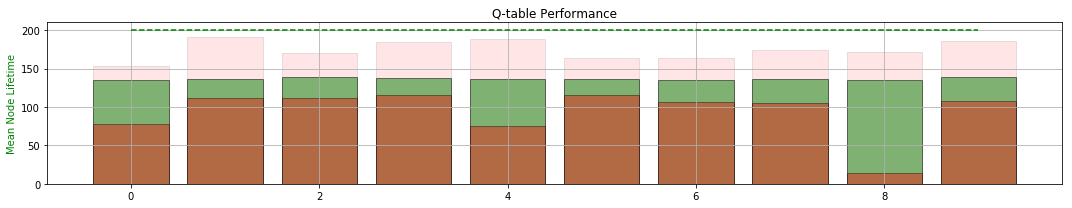

MEMORY COUNTER:  200000
Training Neural Network for 20000 iterations @ LR =  0.001
LOSS : 92.837	LOSS : 73.450	LOSS : 93.180	LOSS : 91.586	LOSS : 100.425	LOSS : 107.858	LOSS : 119.102	LOSS : 99.652	
Validating... MEAN TIME:  169.495
LOSS : 116.754	LOSS : 102.320	LOSS : 129.753	LOSS : 121.902	LOSS : 168.377	LOSS : 132.590	LOSS : 142.094	LOSS : 125.210	
Validating... MEAN TIME:  126.945
LOSS : 137.667	LOSS : 136.488	LOSS : 119.828	LOSS : 112.648	LOSS : 116.177	LOSS : 99.209	LOSS : 119.271	LOSS : 138.702	
Validating... MEAN TIME:  107.58
LOSS : 128.988	LOSS : 132.016	LOSS : 139.341	LOSS : 134.835	LOSS : 146.781	LOSS : 139.429	LOSS : 109.726	LOSS : 138.525	
Validating... MEAN TIME:  115.42
LOSS : 121.555	LOSS : 128.453	LOSS : 120.268	LOSS : 114.988	LOSS : 128.992	LOSS : 136.476	LOSS : 116.986	LOSS : 142.453	
Validating... MEAN TIME:  111.97
TRAINING TIME:0:00:51.946113


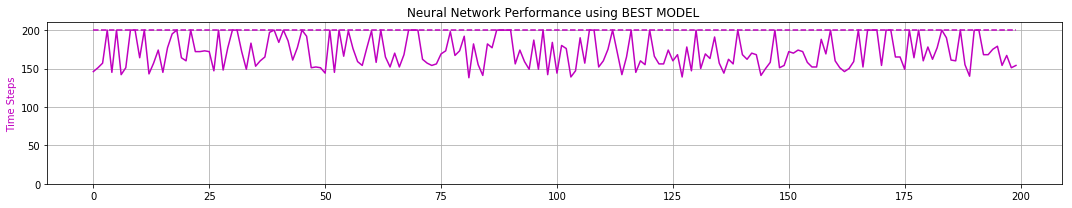

peak memory: 1455.35 MiB, increment: 1017.07 MiB
0 -max- [ 0.154  1.164  0.081  1.668]
0 -min- [-2.400 -3.341 -0.209 -1.812]

1 -max- [ 0.188  1.021  0.057  1.522]
1 -min- [-2.398 -3.364 -0.208 -1.562]

2 -max- [ 0.137  1.155  0.050  1.616]
2 -min- [-2.399 -3.350 -0.209 -1.739]

3 -max- [ 0.151  1.021  0.085  1.699]
3 -min- [-2.400 -3.364 -0.208 -1.631]

4 -max- [ 0.179  1.022  0.048  1.559]
4 -min- [-2.400 -3.356 -0.209 -1.744]

5 -max- [ 0.149  1.022  0.049  1.500]
5 -min- [-2.399 -3.364 -0.207 -1.530]

6 -max- [ 0.140  1.015  0.083  1.675]
6 -min- [-2.400 -3.363 -0.208 -1.645]

7 -max- [ 0.170  1.124  0.078  1.660]
7 -min- [-2.399 -3.509 -0.207 -1.706]

8 -max- [ 0.150  1.185  0.079  1.670]
8 -min- [-2.400 -3.462 -0.206 -1.720]

9 -max- [ 0.150  1.019  0.076  1.514]
9 -min- [-2.400 -3.361 -0.205 -1.574]

Quantization TIME:  0.02 minutes


ITERATION # 31
TOTAL EXPERIENCE GENERATED:   197892
SMALLEST TIMESTEP: 116
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   3942106
TOTAL PARALLEL

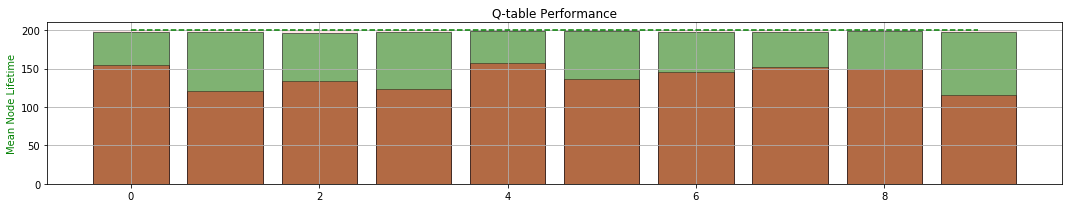

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  5714.0
Total Serial Timesteps   :  3942106.0
Speed-up                 :  689.90


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  9295 SUCCESS 116  31    5714    3942106     689.90
